In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Cài đặt thư viện
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.style.use("ggplot")
import numpy as np 
import pandas as pd 
import os
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

In [ ]:
#Data mining
def data_mining(data):
  from statsmodels.tsa.seasonal import seasonal_decompose
  result = seasonal_decompose(data, model='additive', period=20)
  #chuyển giá trị trên trục x nghiêng 45 độ
  result.observed.index = result.observed.index.strftime('%d-%m-%Y')
  #Tạo 4 subplots
  fig, ax = plt.subplots(4, 1, figsize=(10, 8))
  #Thực hiện gắn dữ liệu vào từng subplot
  result.observed.plot(ax=ax[0])
  ax[0].set_ylabel('Observed')
  result.trend.plot(ax=ax[1])
  ax[1].set_ylabel('Trend')
  result.seasonal.plot(ax=ax[2])
  ax[2].set_ylabel('Seasonal')
  result.resid.plot(ax=ax[3])
  ax[3].set_ylabel('Residual')
  plt.tight_layout()
  plt.show()

In [ ]:
#Chia dữ liệu
def data_spliting(df1, train_ratio, test_ratio):
  train_size = int(train_ratio * len(df1))
  test_size = int(test_ratio * len(df1))
  val_size = len(df1) - train_size - test_size

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size]
  val_data = df1[train_size+test_size:]

  return train_data, test_data, val_data

In [ ]:
def visualize(label ,pred, model_name):
  plt.figure(figsize=(16,9))
  plt.plot(label, label = 'Ground truth')
  plt.plot(label.index, pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [ ]:
#Visualization
def visualize_overview(train_data_df,test_data_df, val_data_df, test_predict_inverse, val_predict_inverse, model_name):

  plt.figure(figsize=(16,9))
  #train label
  plt.plot(train_data_df, label = 'Train')

  #test label and predict value
  plt.plot(test_data_df, label = 'Test')
  plt.plot(test_data_df.index, test_predict_inverse, label='Predict')

  #val label and predict value
  plt.plot(val_data_df, label = 'Validate')
  plt.plot(val_data_df.index, val_predict_inverse, label='ValidatePred')

  #predict next 30 days value
  # plt.plot(next30_predict_inverse, label = 'Predict30days')


  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [ ]:
#Đánh giá 
def deviation(test, pred):
  rmse=np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape=mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

In [ ]:
def arima_fit(train_data, test_data, val_data, model_name):
  fit_model = auto_arima(train_data, seasonal=False, trace=True)
  fit_model.summary()


  #dự đoán tập test
  test_predict = fit_model.predict(len(test_data))
  deviation(test_data, test_predict)
  visualize(test_data, test_predict, model_name)

  #dự đoán tập validate
  val_predict = fit_model.predict(len(val_data))
  deviation(val_data, val_predict)
  visualize(val_data, val_predict, model_name)





  # next30_predict_inverse = arima_next30days(model, scaler , y_val, val_data_df, time_step)
  visualize_overview(train_data, test_data, val_data, test_predict, val_predict, model_name)

In [ ]:
#Chọn dataset, tỉ lệ và 
def data_preprocessing(data_src, train_ratio, test_ratio, model_name):
  df = pd.read_csv(data_src, parse_dates=True,
                       index_col=0).sort_values(by='Date', ascending=True)
  #Xóa dấu , và chuyển về float
  df['Price']=df['Price'].replace(',','',regex=True).astype(float)
  df['Open']=df['Open'].astype(str).str.replace(',','').astype(float)
  df['High']=df['High'].astype(str).str.replace(',','').astype(float)
  df['Low']=df['Low'].astype(str).str.replace(',','').astype(float)
  df['Change %']=df['Change %'].astype(str).str.replace('%','').astype(float)

  #Thực hiện tách chuỗi KL thành 1 chuỗi số float và 1 ký tự cuối sau đó lấy số float đó nhân với 1000 
  #nếu ký tự cuối là K, nếu là M thì nhân với 1000000, nếu không có K hay M thì trả về số float đó
  def convert_value(value):
      if isinstance(value, str):
          if value.endswith('K'):
              return float(value[:-1]) * 1000
          elif value.endswith('M'):
              return float(value[:-1]) * 1000000
          else:
              return float(value)
      else:
          return value

  df['Vol.'] = df['Vol.'].apply(convert_value)

  df = df[['Price']]

  data_mining(df)

  df1 = df
  
  train_data, test_data, val_data = data_spliting(df1,train_ratio, test_ratio)

  model =  arima_fit(train_data, test_data, val_data, model_name)


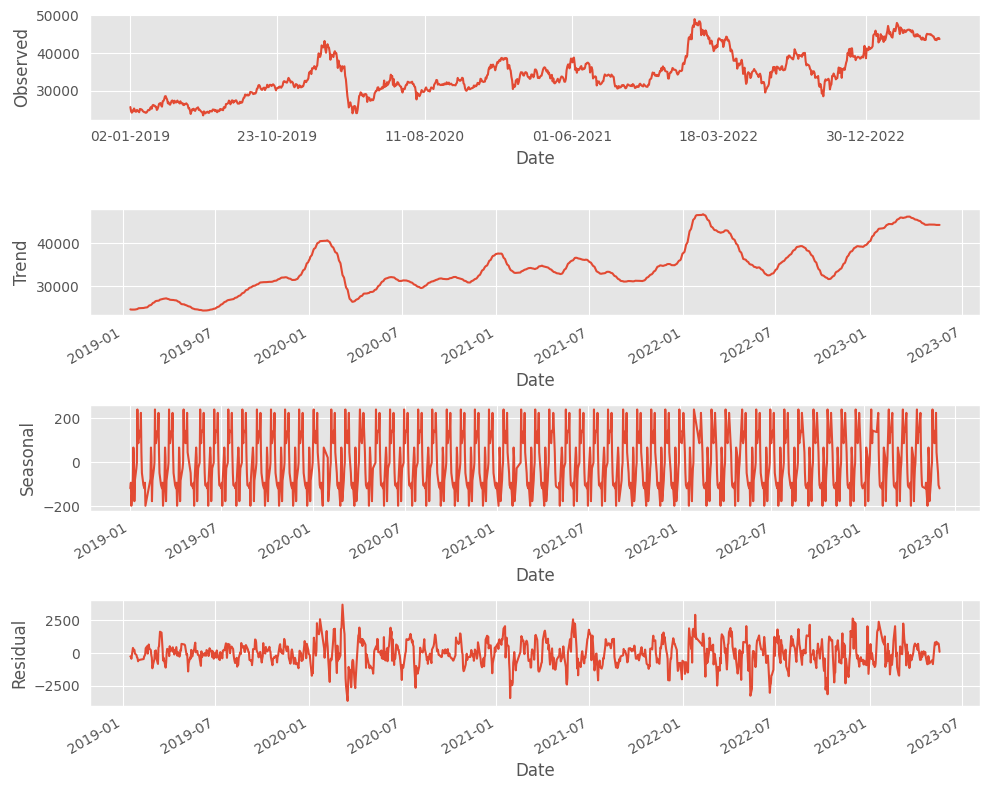

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10495.948, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10488.138, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10490.055, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10490.052, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10486.234, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10492.011, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.041 seconds
RMSE: 7111.10
MAPE: 13.94%
MAE: 5536.03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


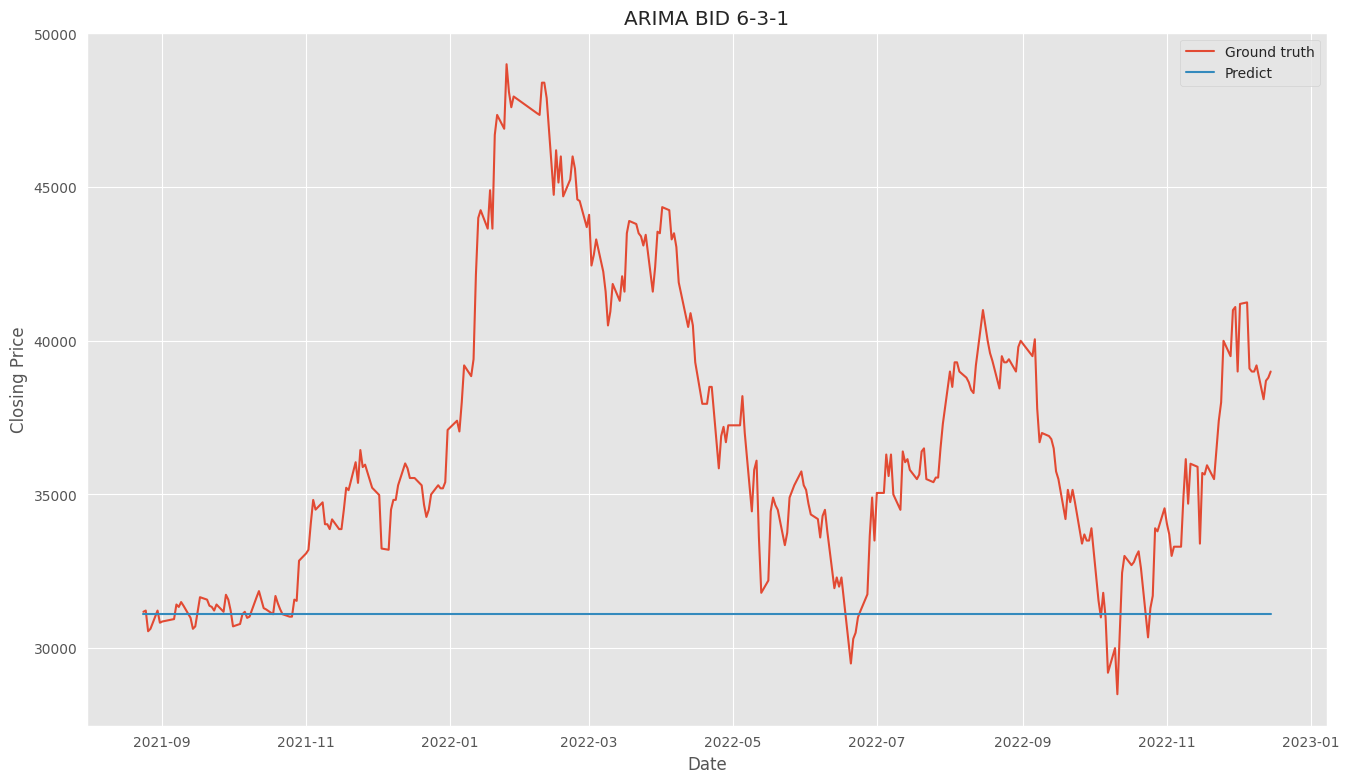

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 13161.95
MAPE: 29.27%
MAE: 12984.64


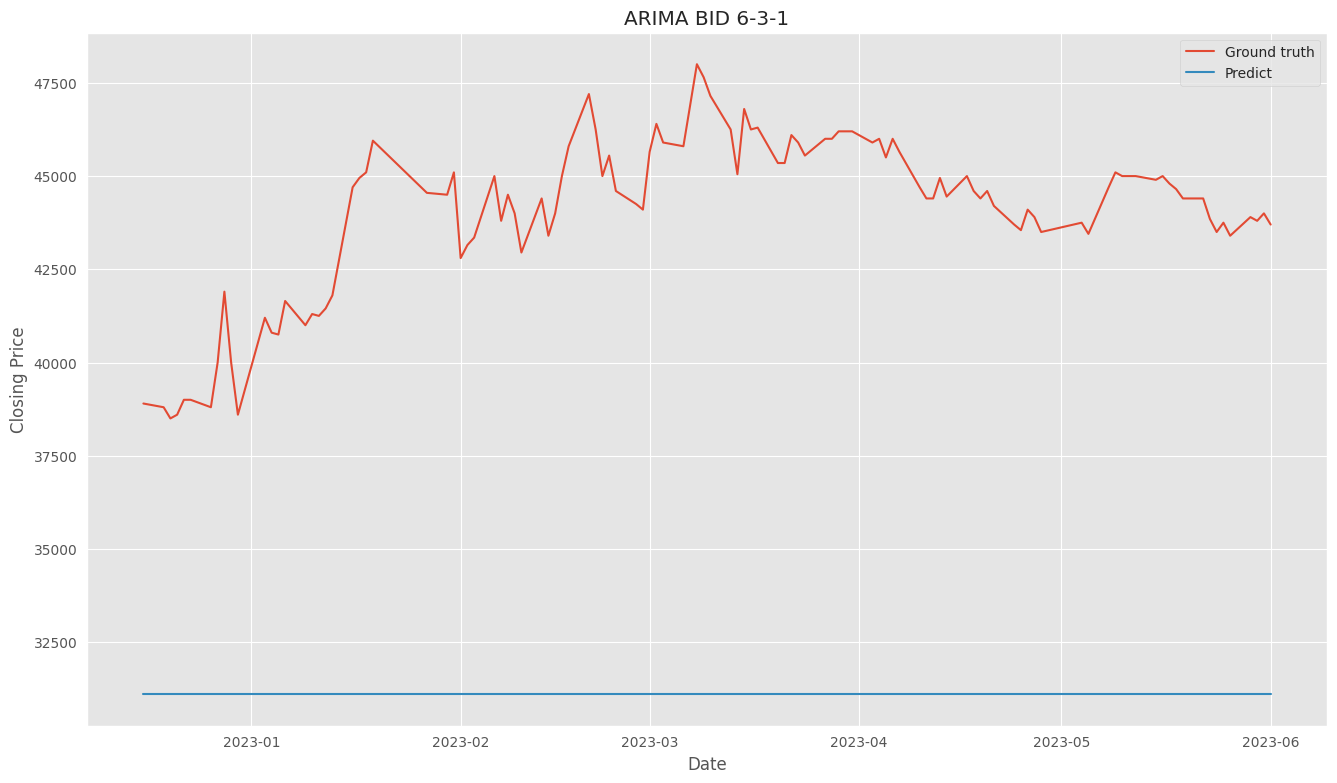

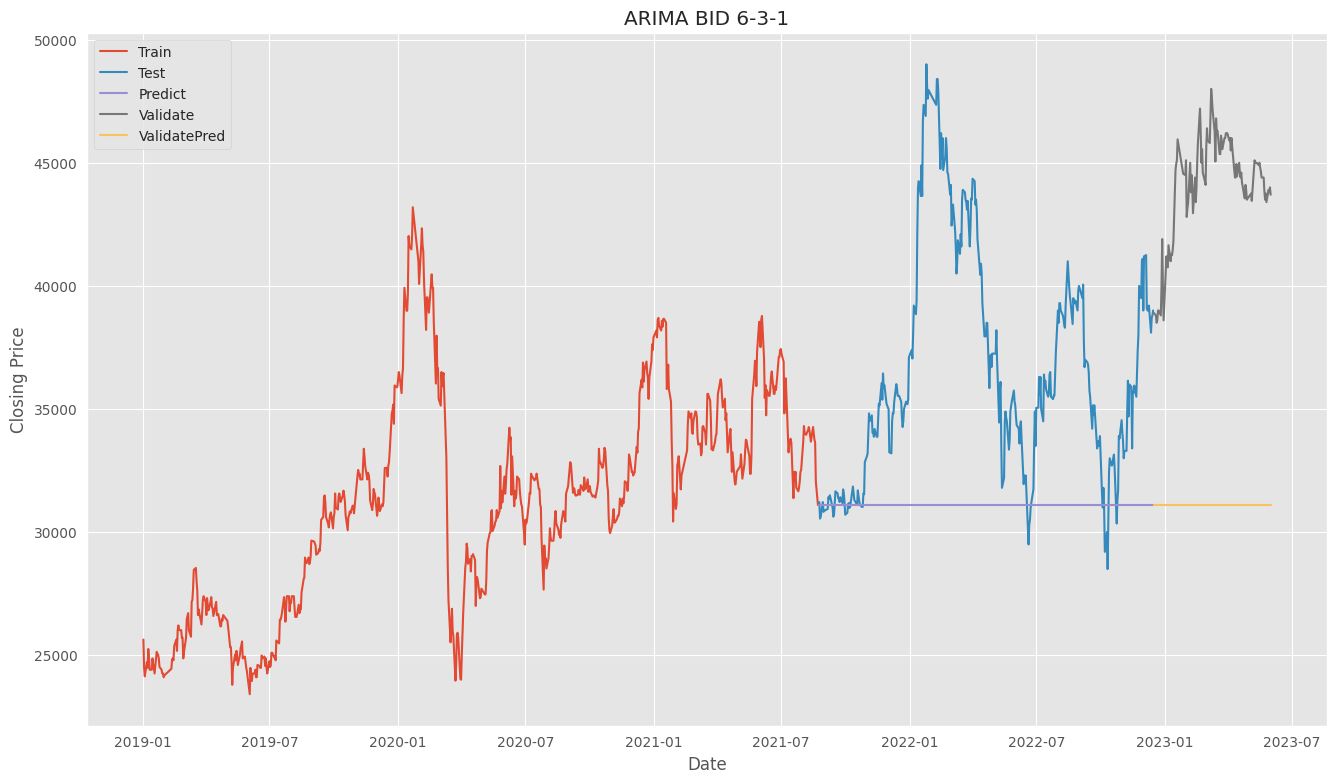

In [ ]:
data_preprocessing('/content/BID Historical Data.csv', 0.6, 0.3, "ARIMA BID 6-3-1")

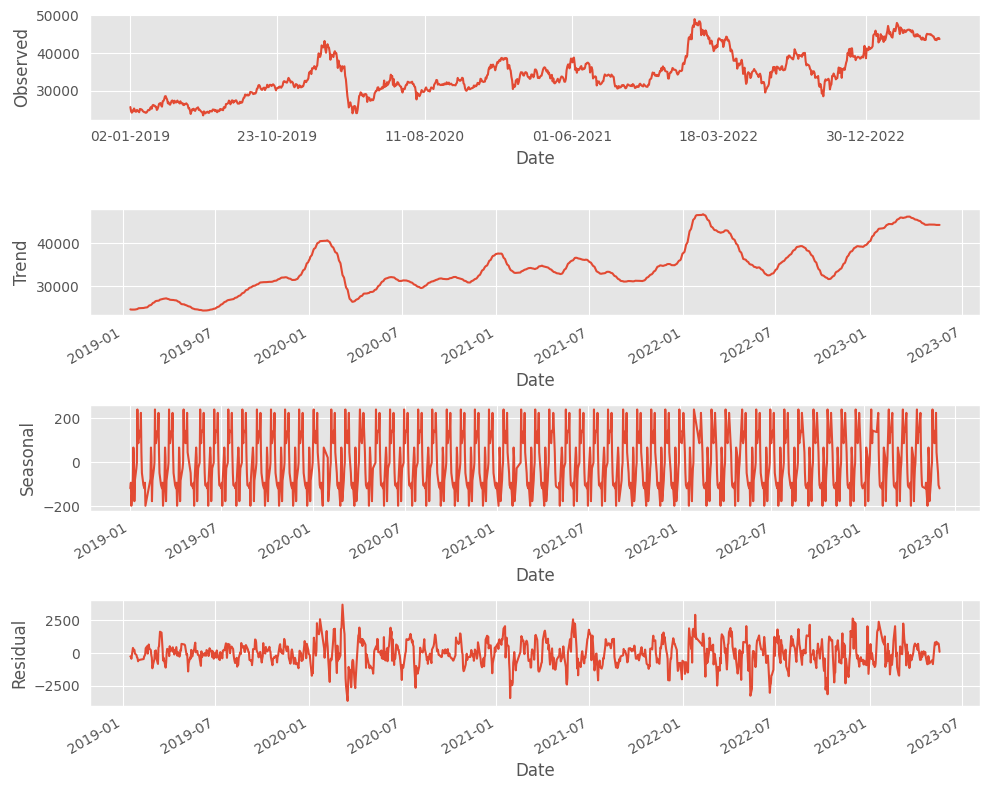

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12250.756, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12243.116, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12245.057, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12245.055, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12242.427, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12247.049, Time=0.83 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.705 seconds
RMSE: 11006.56
MAPE: 28.70%
MAE: 10138.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


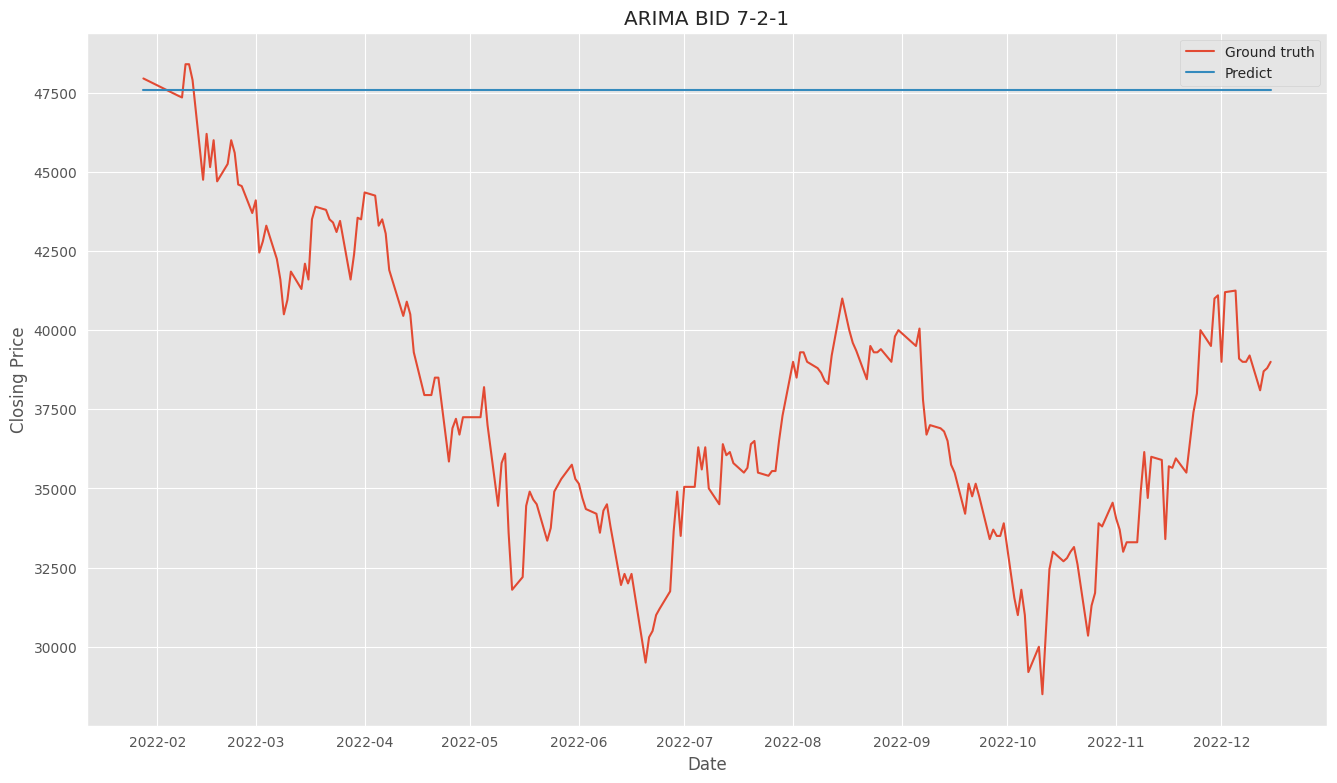

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 4119.65
MAPE: 8.26%
MAE: 3520.27


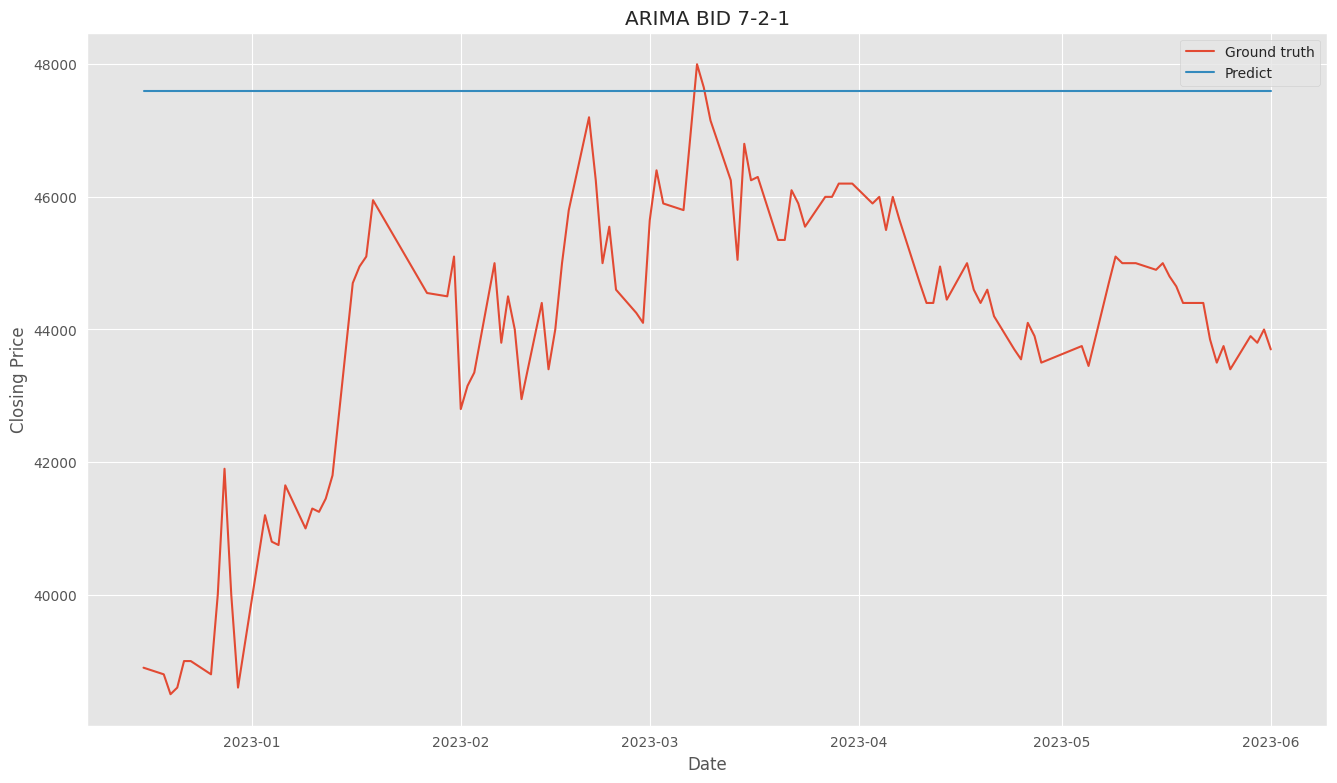

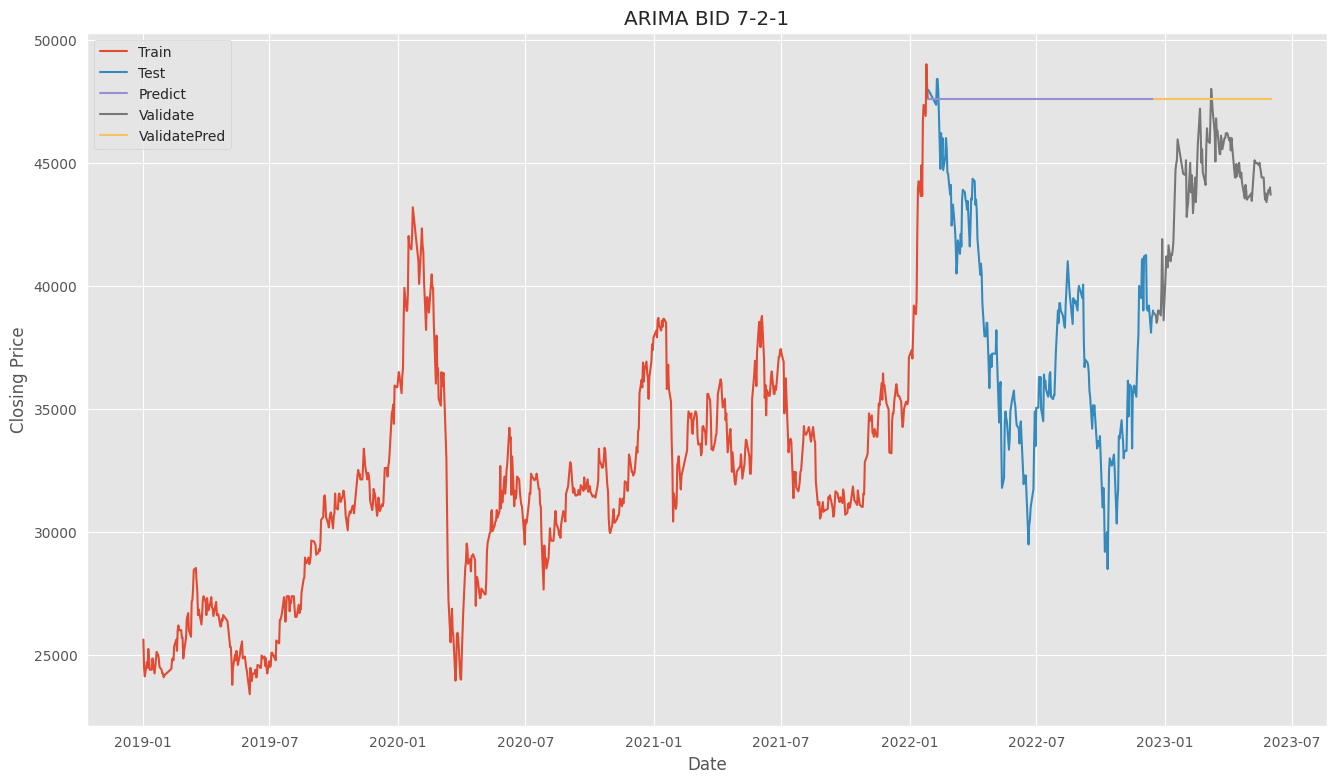

In [ ]:
data_preprocessing('/content/BID Historical Data.csv', 0.7, 0.2, "ARIMA BID 7-2-1")

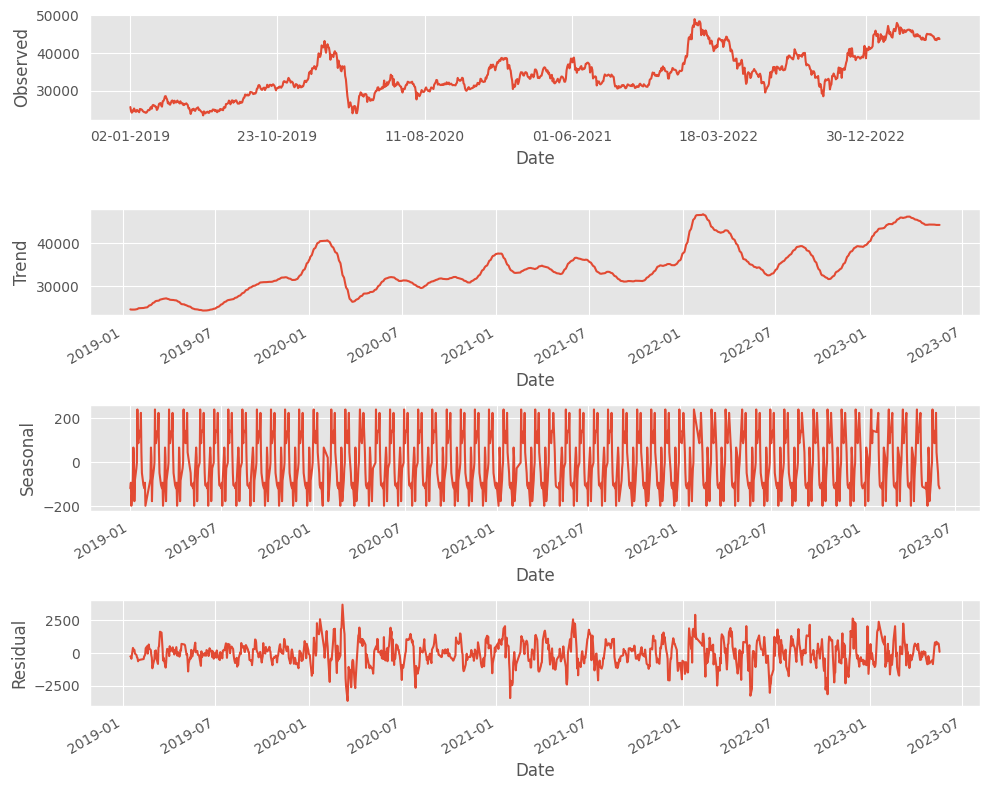

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14111.601, Time=3.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14114.705, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14116.193, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14116.182, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14112.945, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14119.659, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14120.085, Time=0.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14121.714, Time=1.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14115.869, Time=1.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14118.161, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14118.374, Time=1.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14118.965, Time=2.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=1.54 sec

Best model:  ARIMA(2,1,2)(0,0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


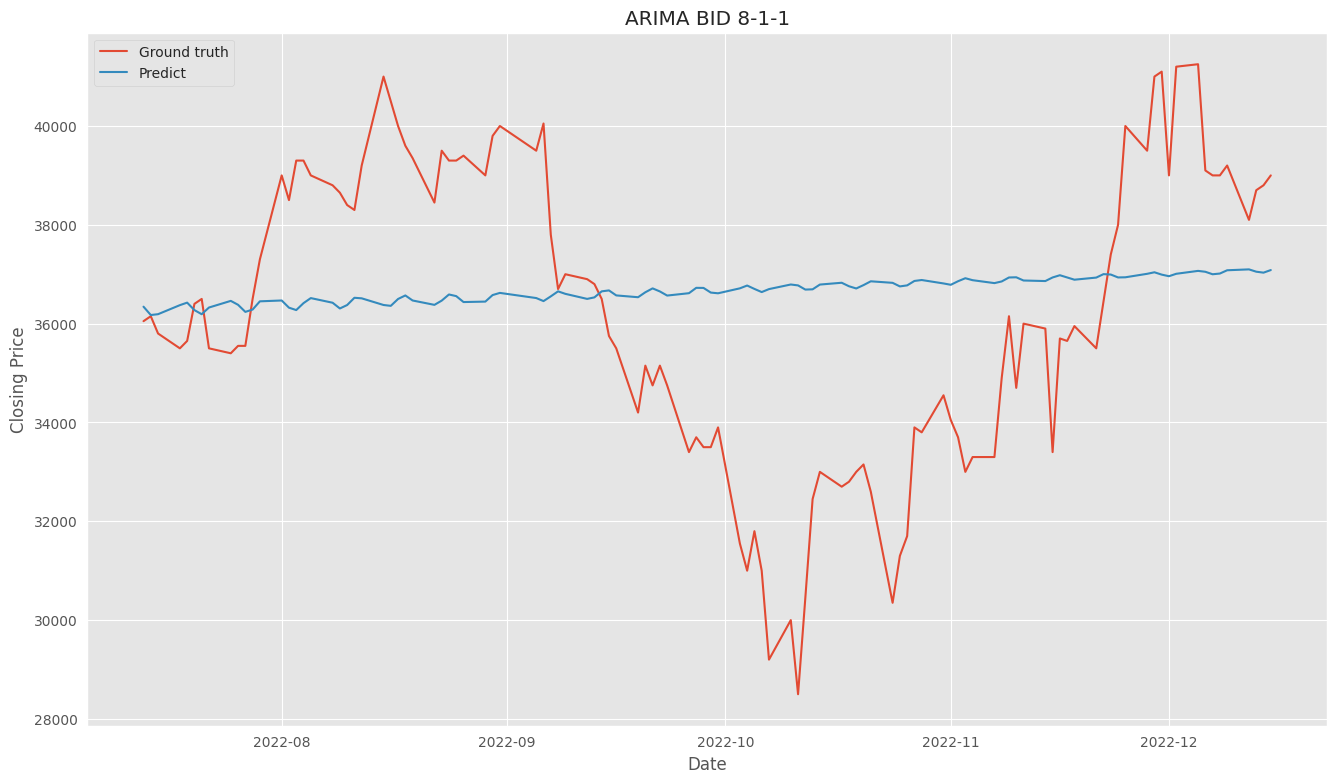

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 7680.90
MAPE: 16.60%
MAE: 7405.78


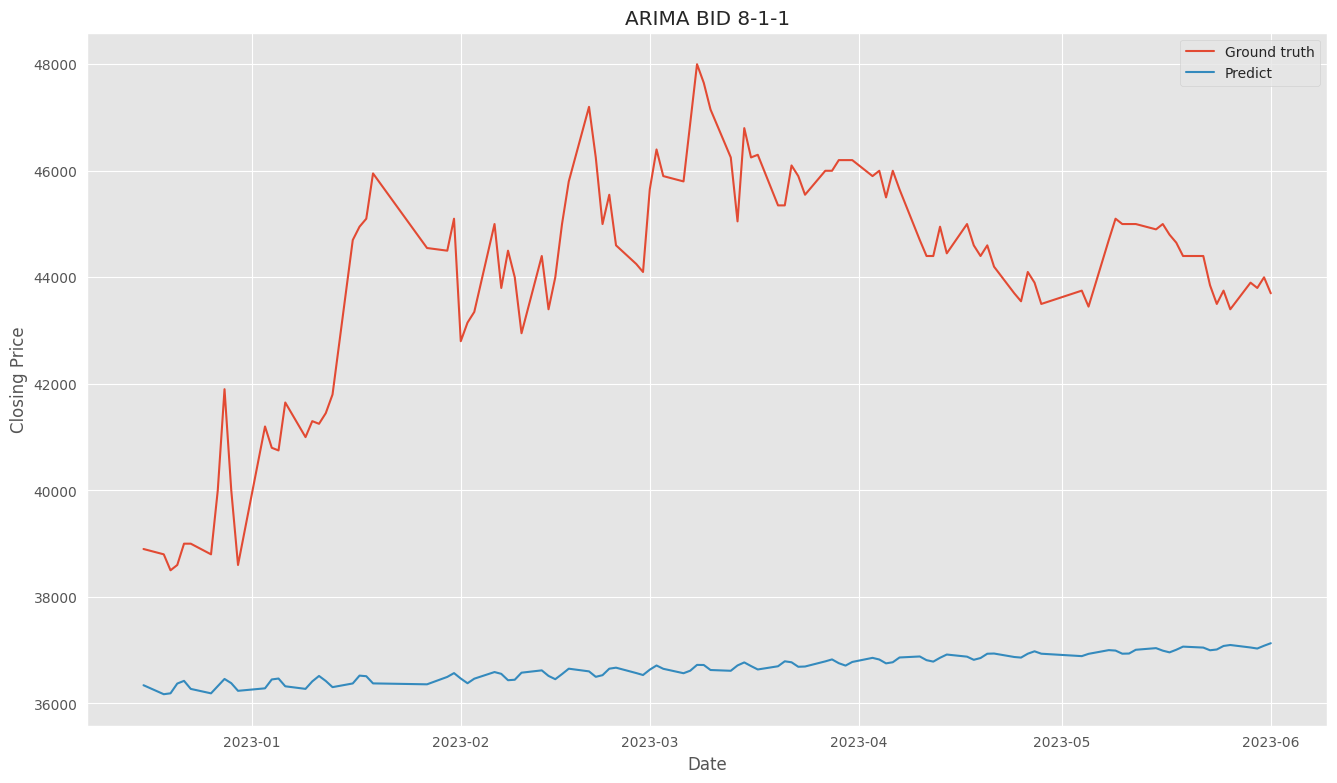

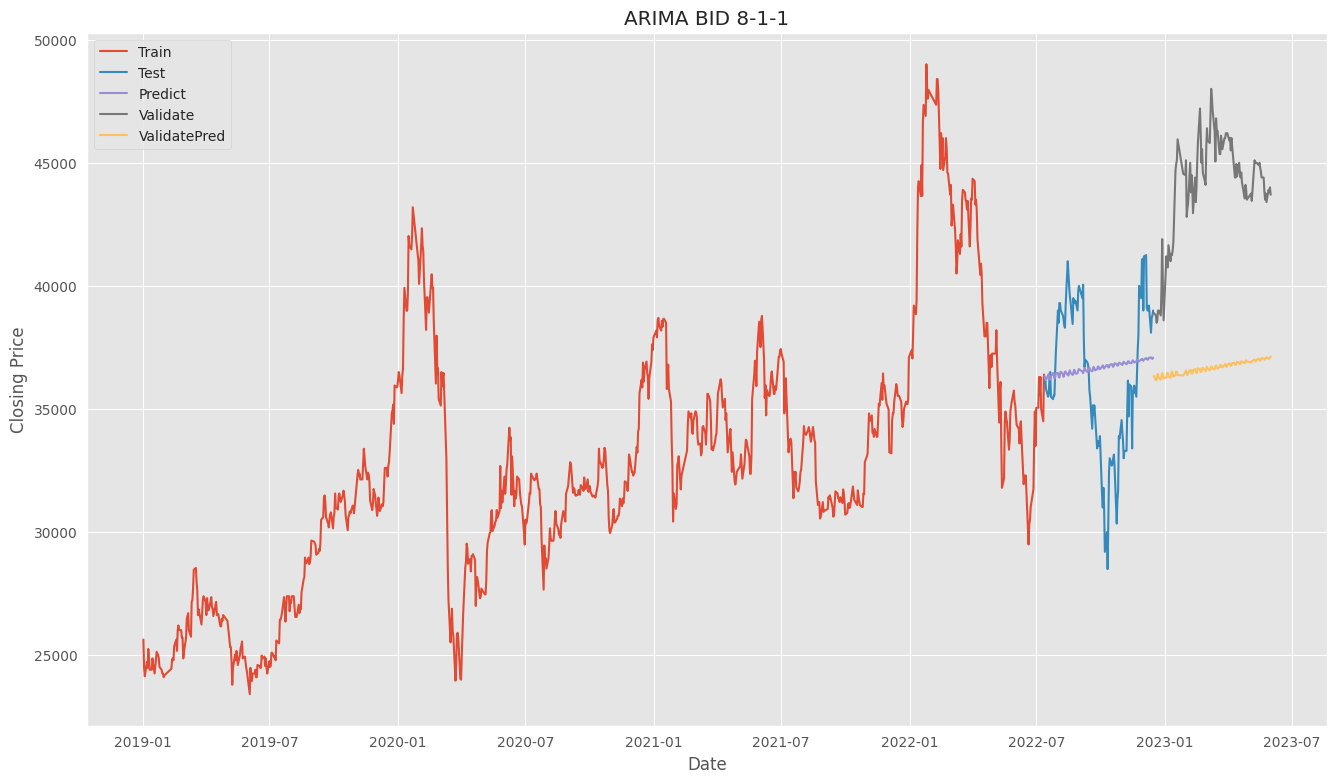

In [ ]:
data_preprocessing('/content/BID Historical Data.csv', 0.8, 0.1, "ARIMA BID 8-1-1")

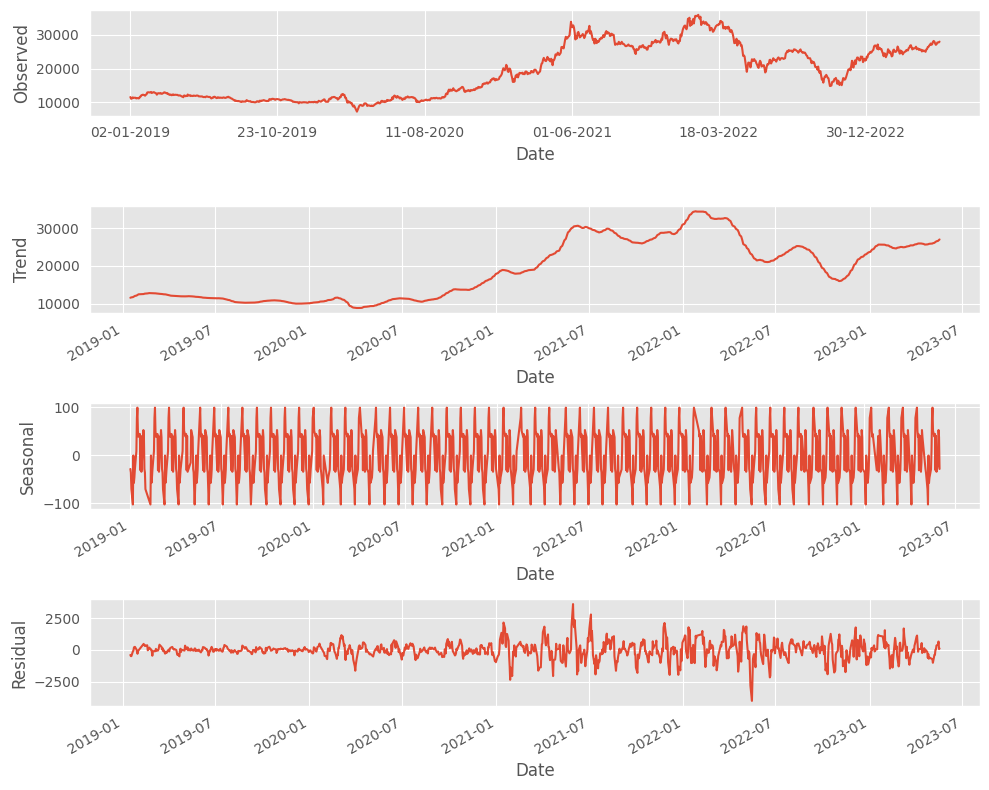

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9838.299, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9840.202, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9840.196, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9838.327, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9842.087, Time=0.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.782 seconds
RMSE: 8692.39
MAPE: 31.75%
MAE: 6633.54


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


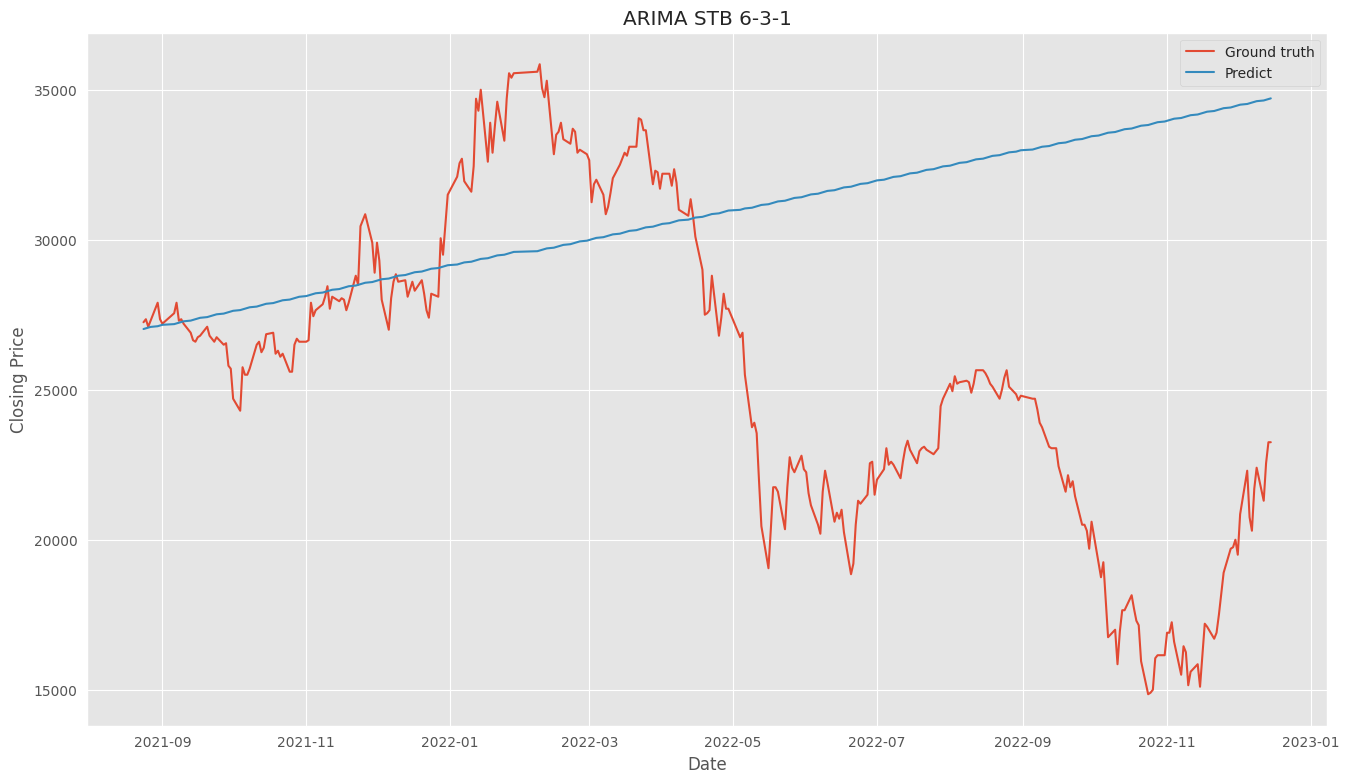

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 3118.21
MAPE: 11.89%
MAE: 2957.75


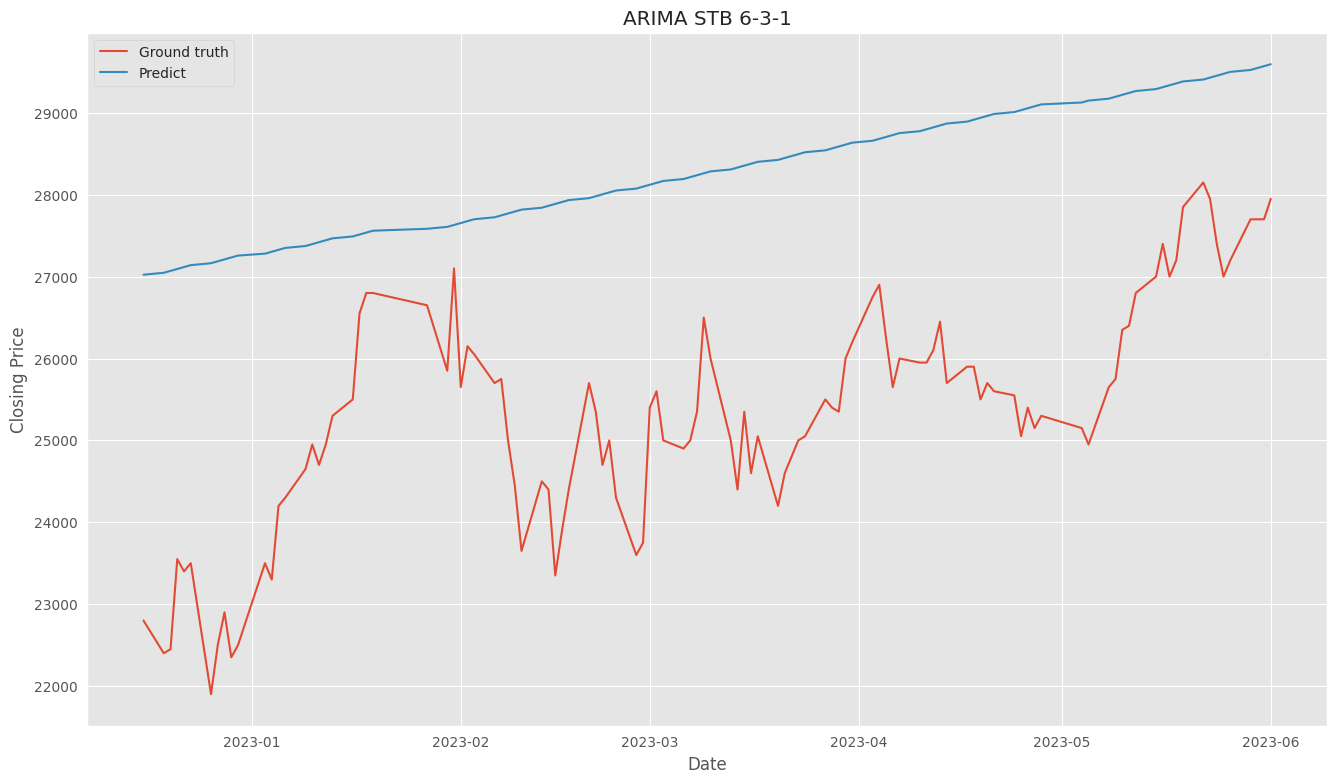

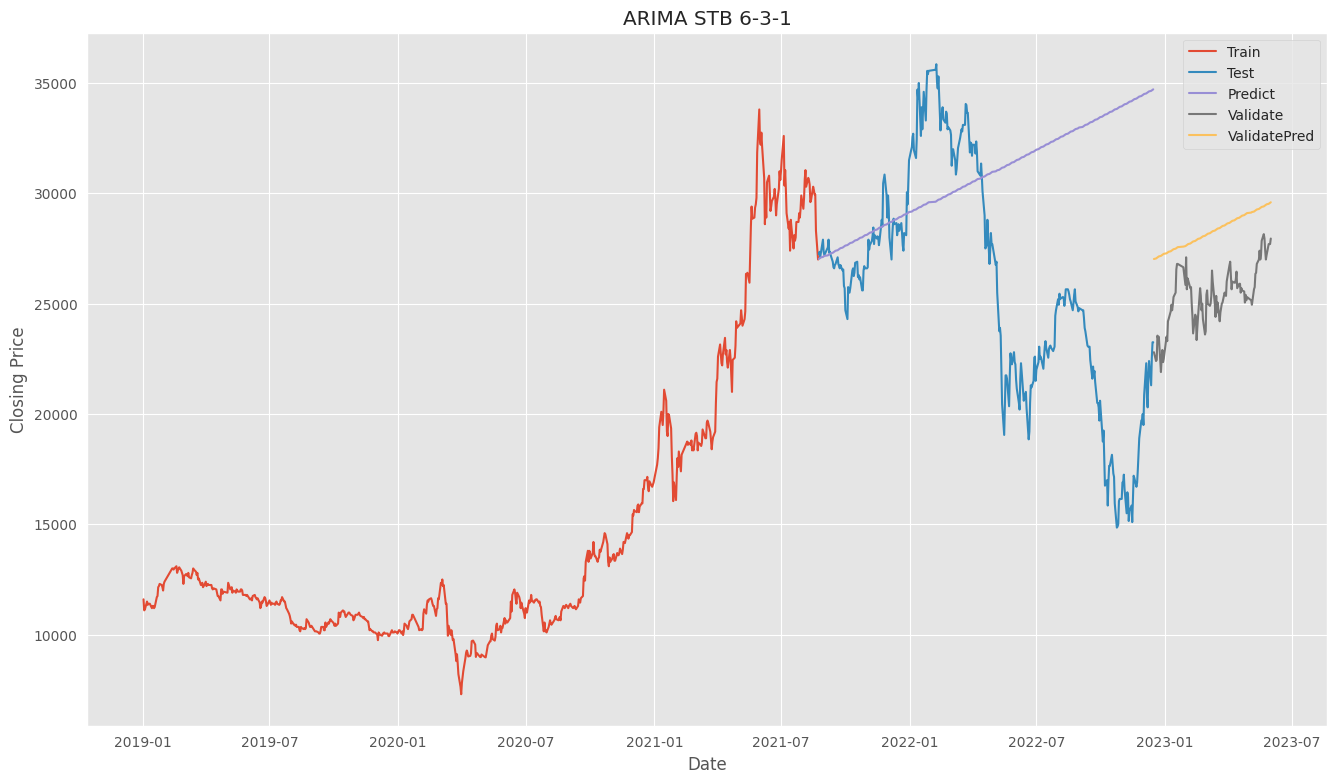

In [ ]:
data_preprocessing('/content/STB Historical Data.csv', 0.6, 0.3, "ARIMA STB 6-3-1")

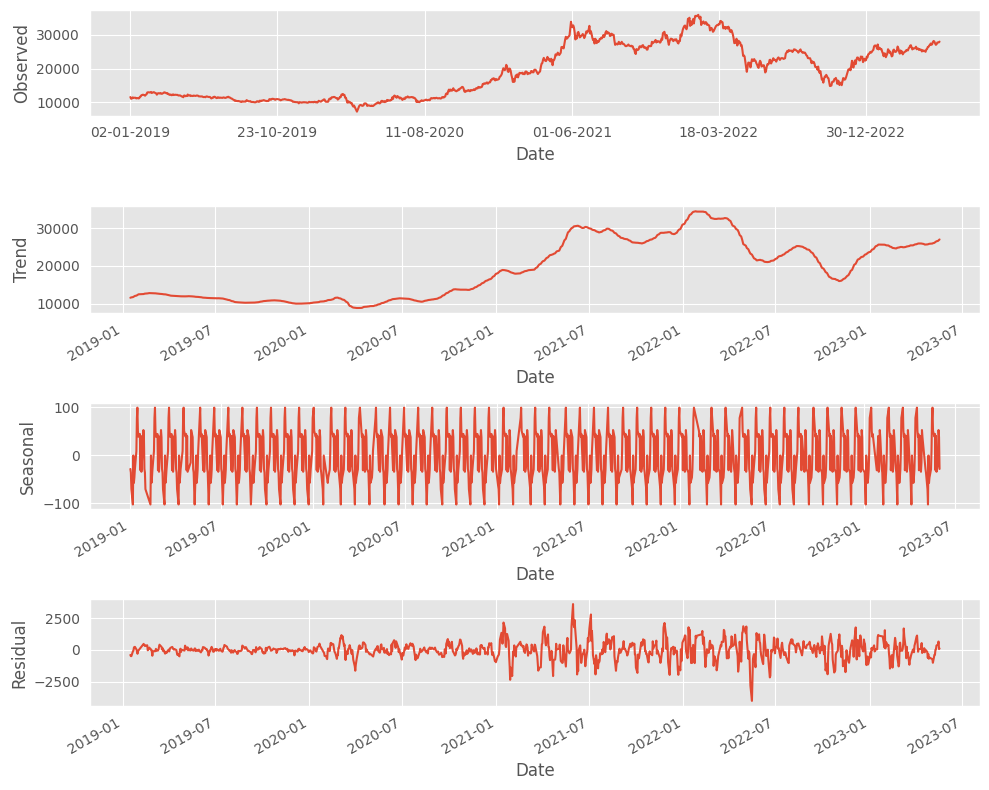

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11656.467, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11651.101, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11651.370, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11651.352, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11652.421, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11653.355, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.566 seconds
RMSE: 16389.10
MAPE: 71.07%
MAE: 14686.62


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


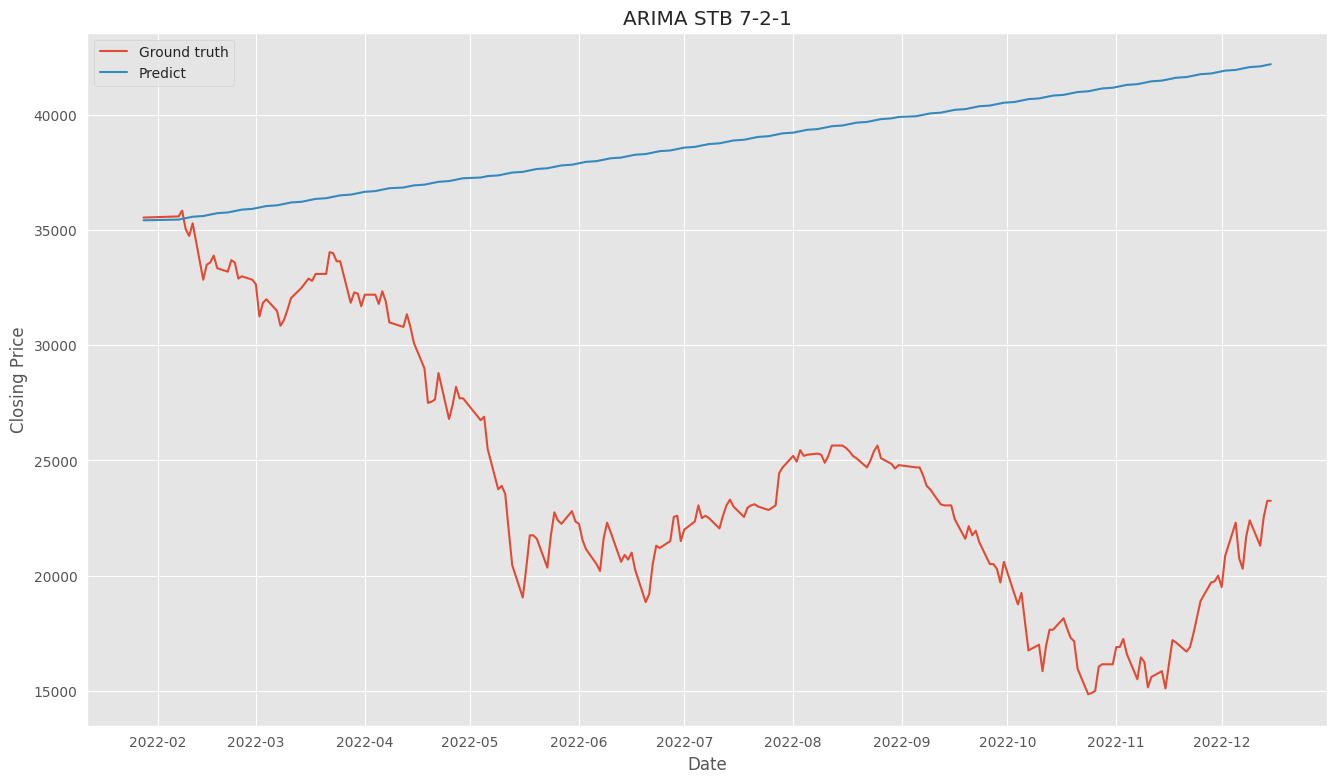

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 11821.22
MAPE: 46.76%
MAE: 11782.26


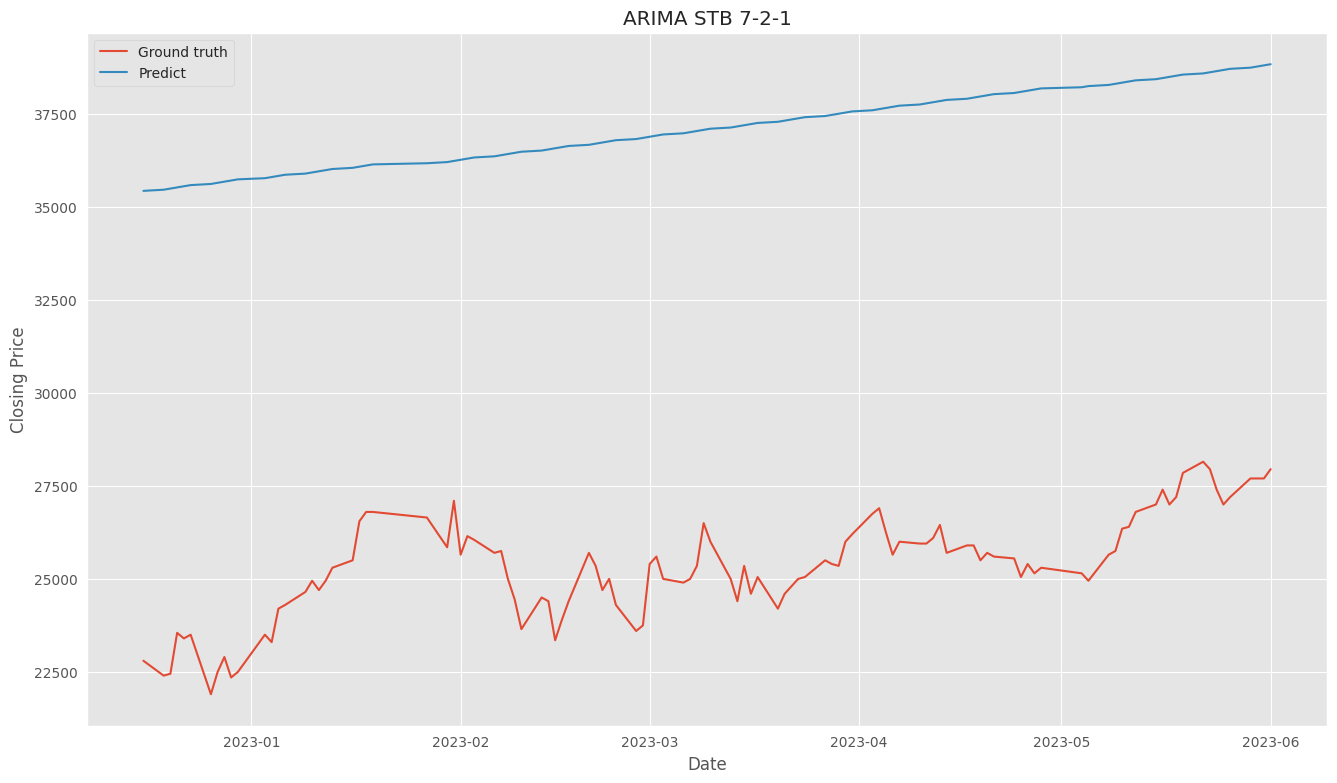

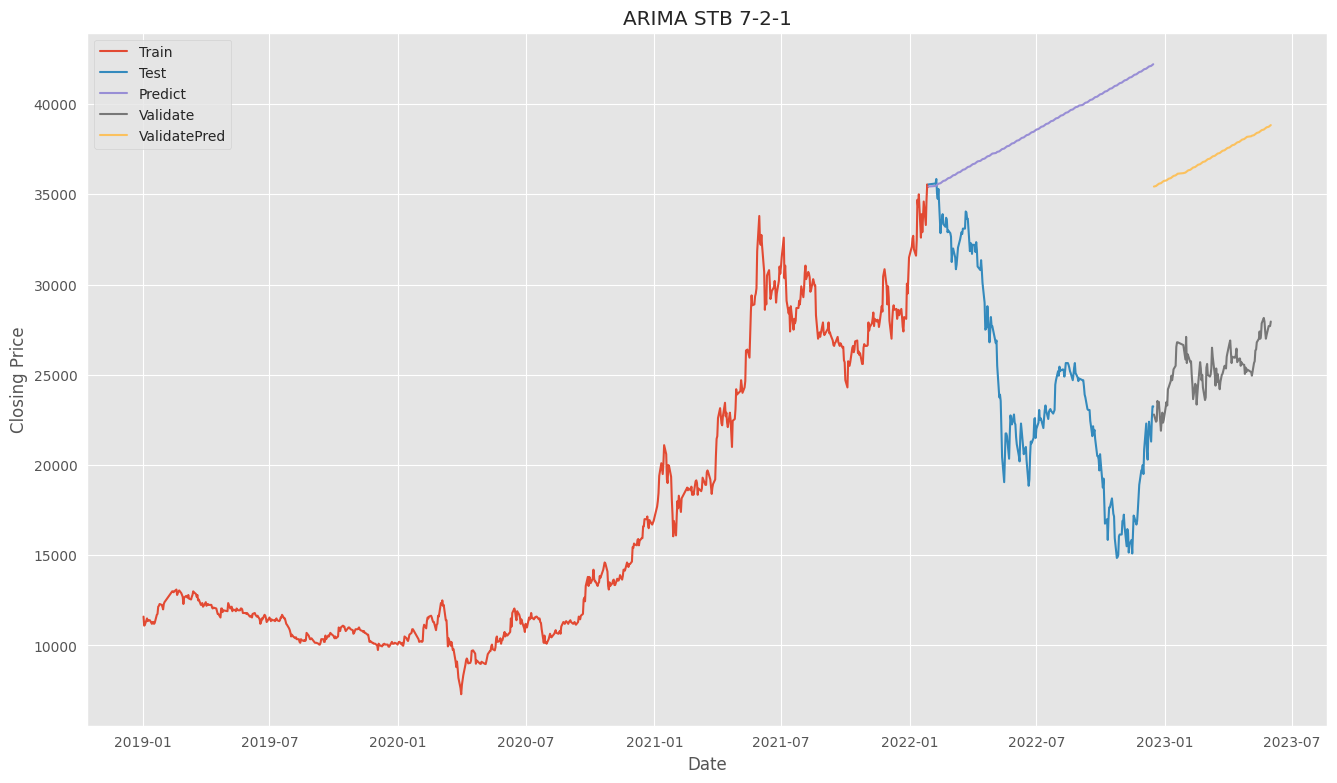

In [ ]:
data_preprocessing('/content/STB Historical Data.csv', 0.7, 0.2, "ARIMA STB 7-2-1")

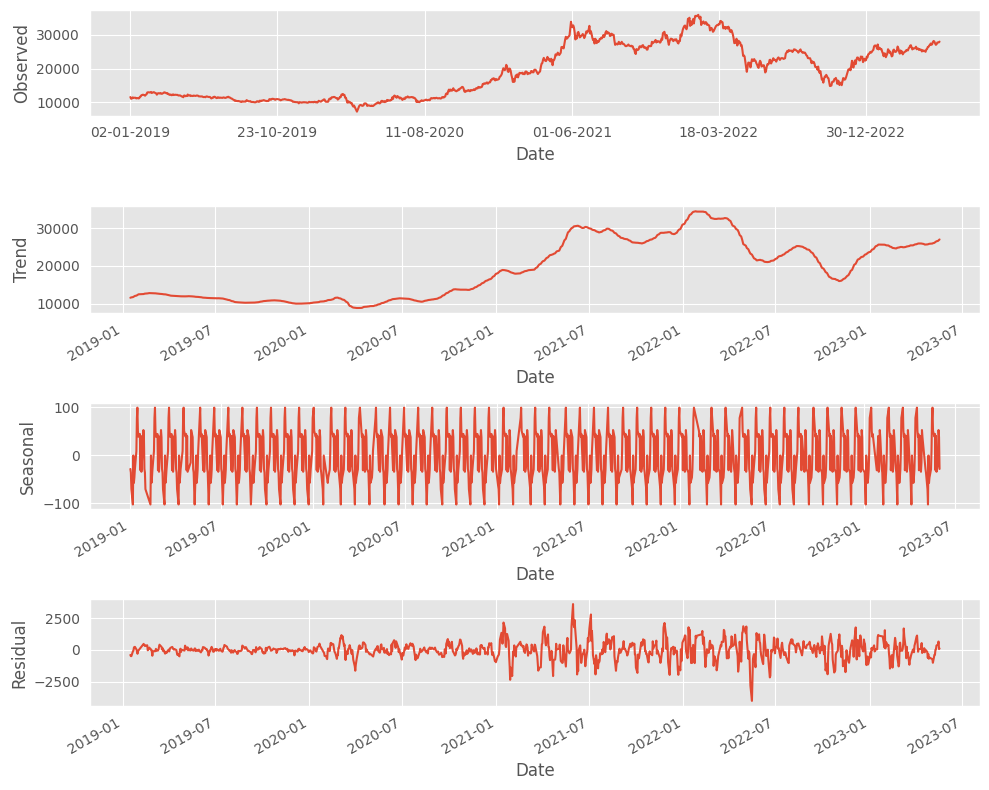

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13491.551, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13492.977, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13494.717, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13494.701, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13491.486, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13496.327, Time=1.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.460 seconds
RMSE: 3875.37
MAPE: 17.23%
MAE: 3150.91


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


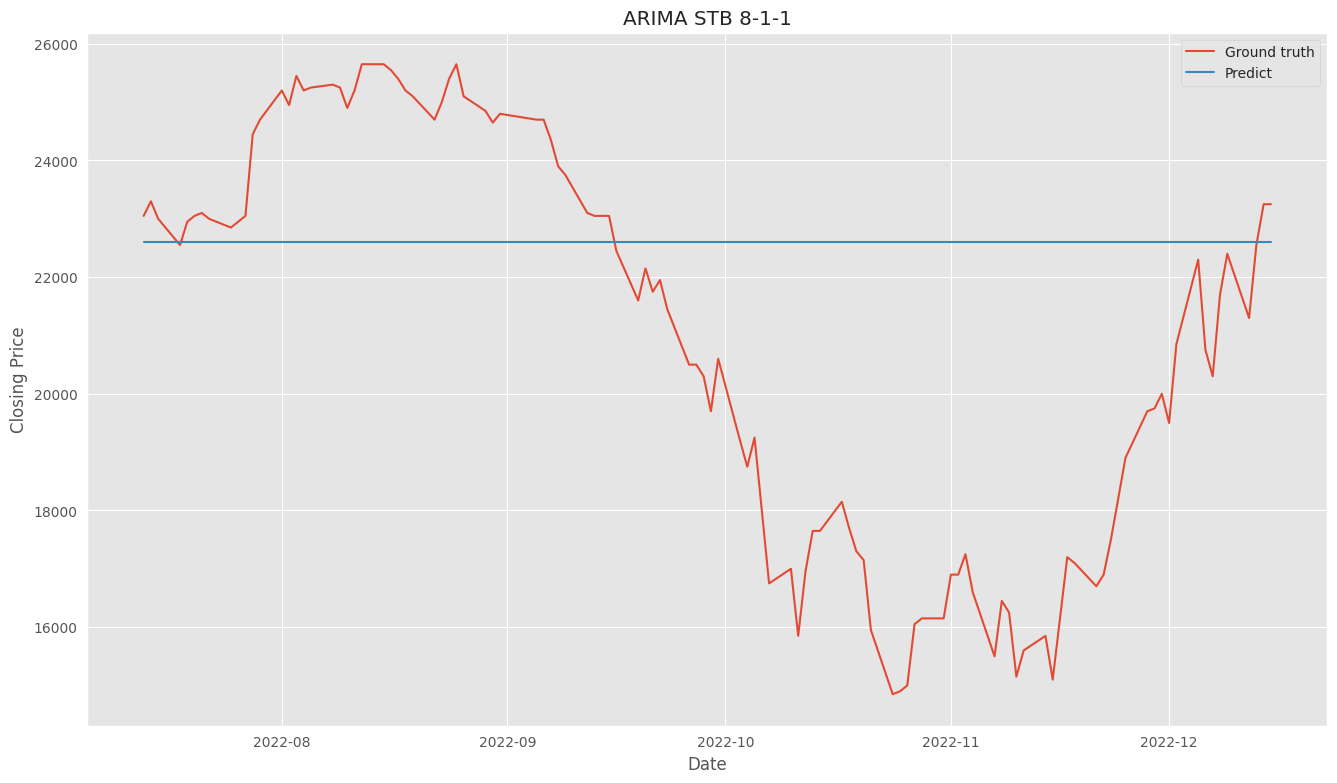

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 3074.98
MAPE: 10.71%
MAE: 2777.93


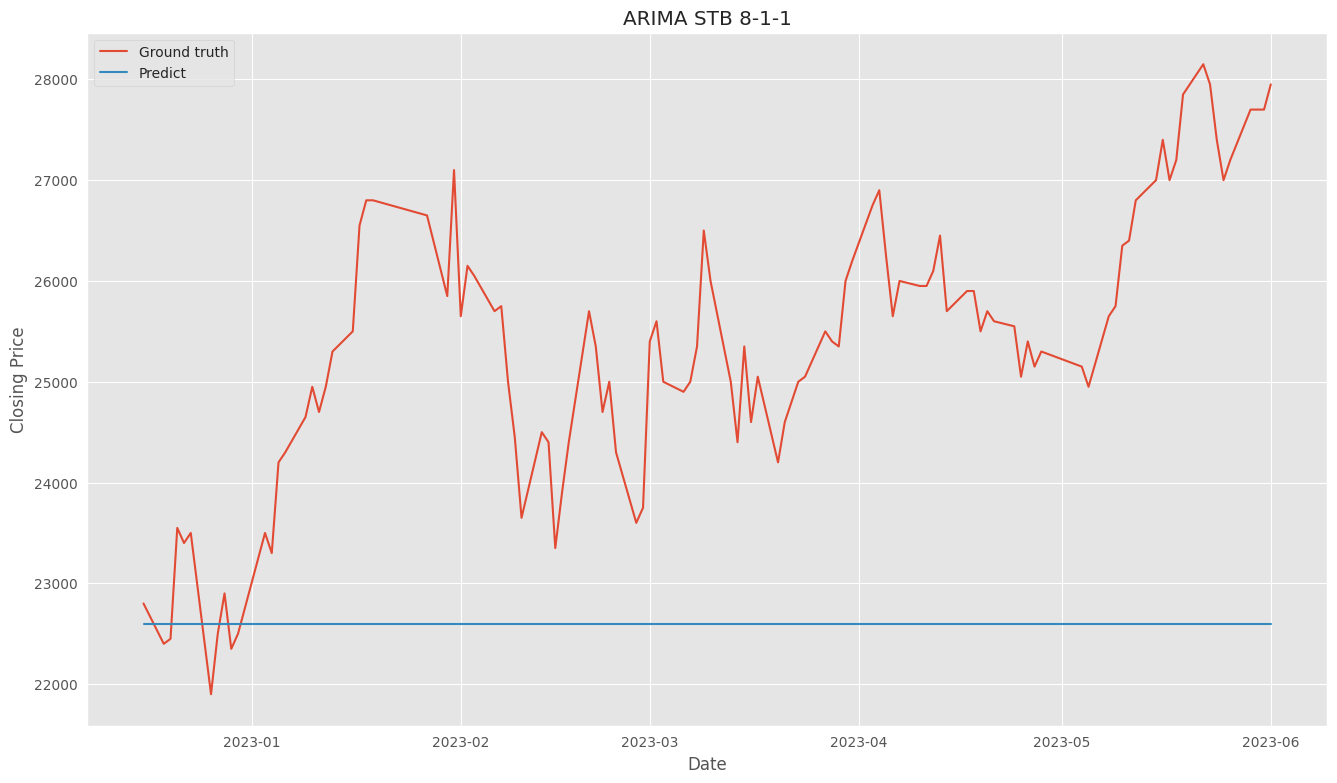

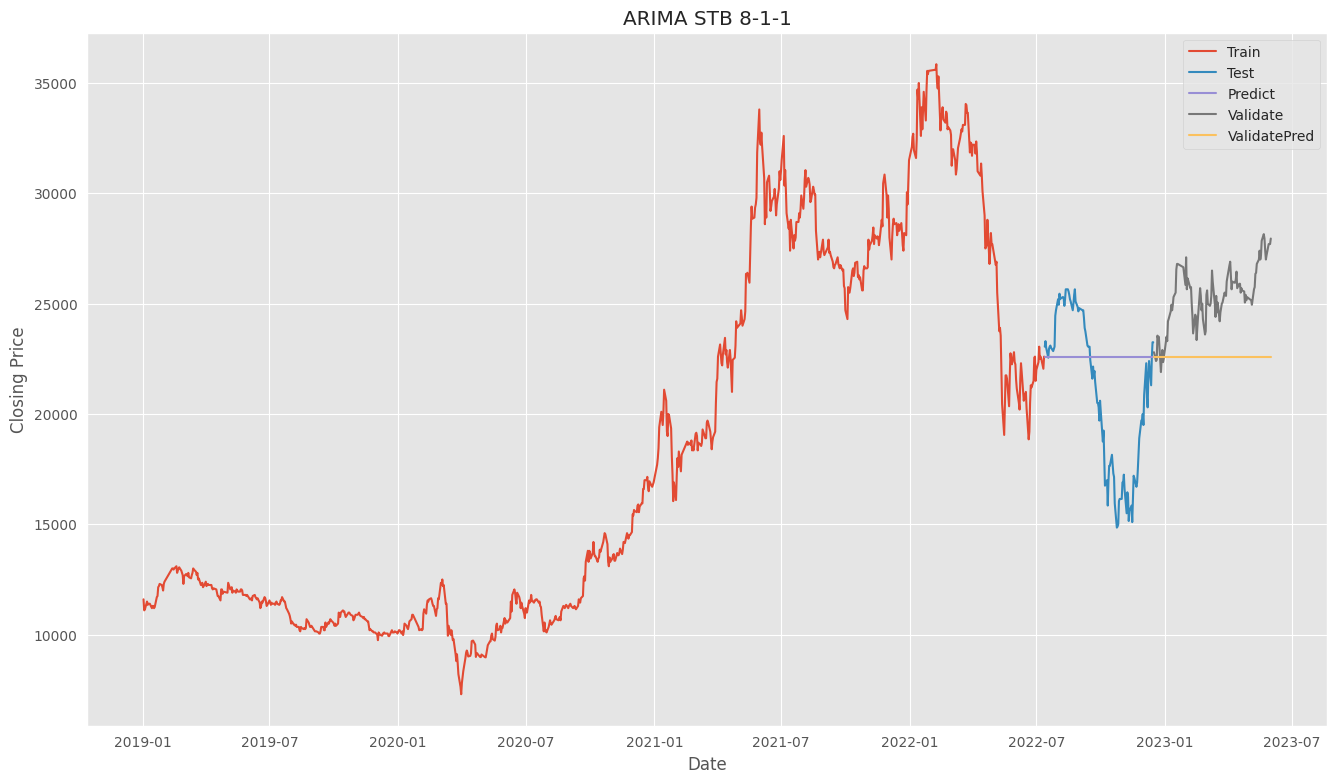

In [ ]:
data_preprocessing('/content/STB Historical Data.csv', 0.8, 0.1, "ARIMA STB 8-1-1")

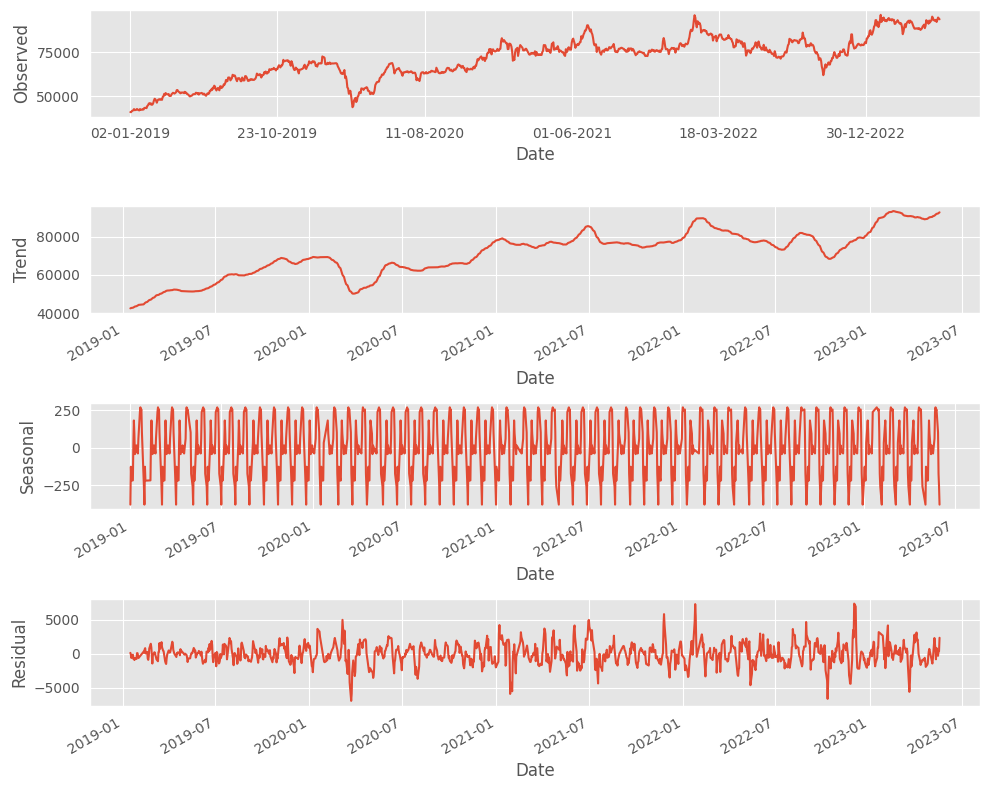

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11177.157, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11178.216, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11180.199, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11180.210, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11177.524, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11182.929, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11183.048, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11177.719, Time=1.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11177.781, Time=0.95 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11182.204, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11182.671, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11182.959, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11179.728, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=11176.033, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


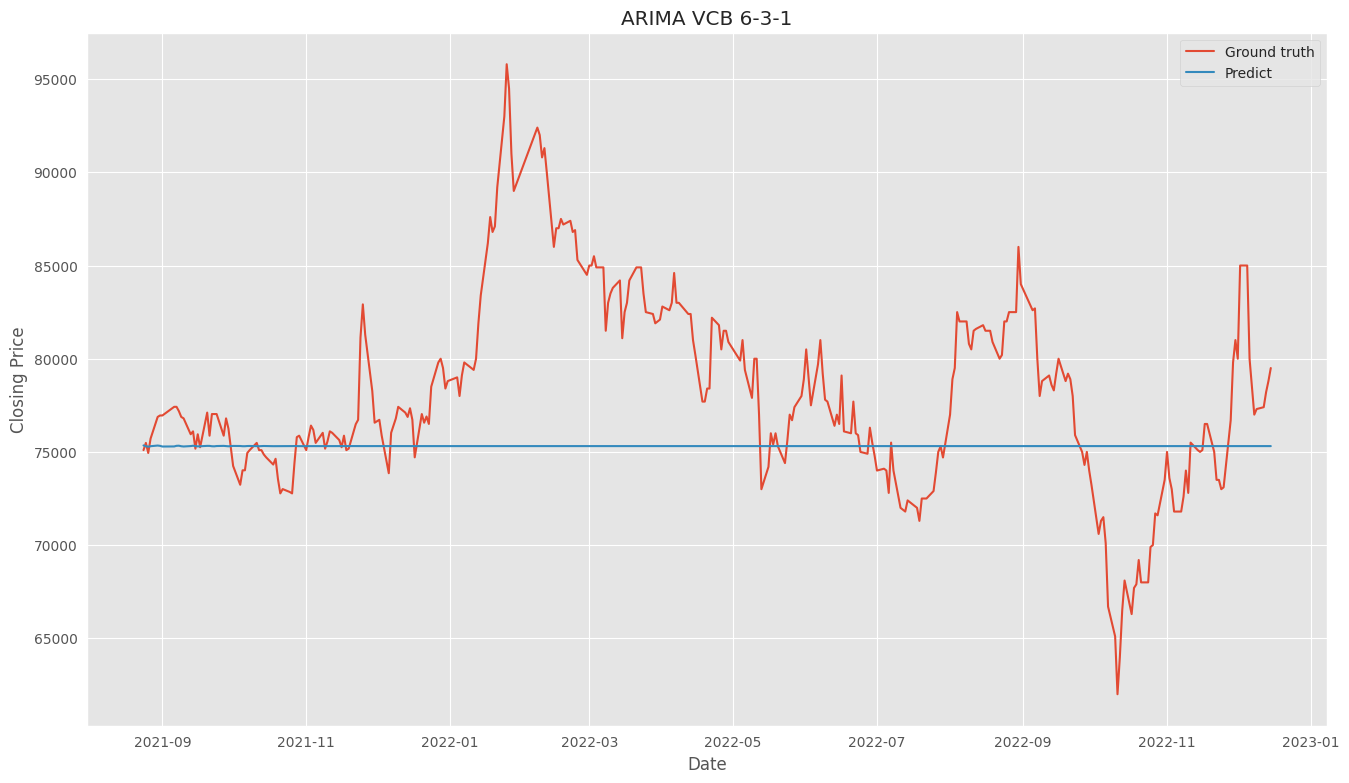

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 15009.61
MAPE: 15.81%
MAE: 14368.84


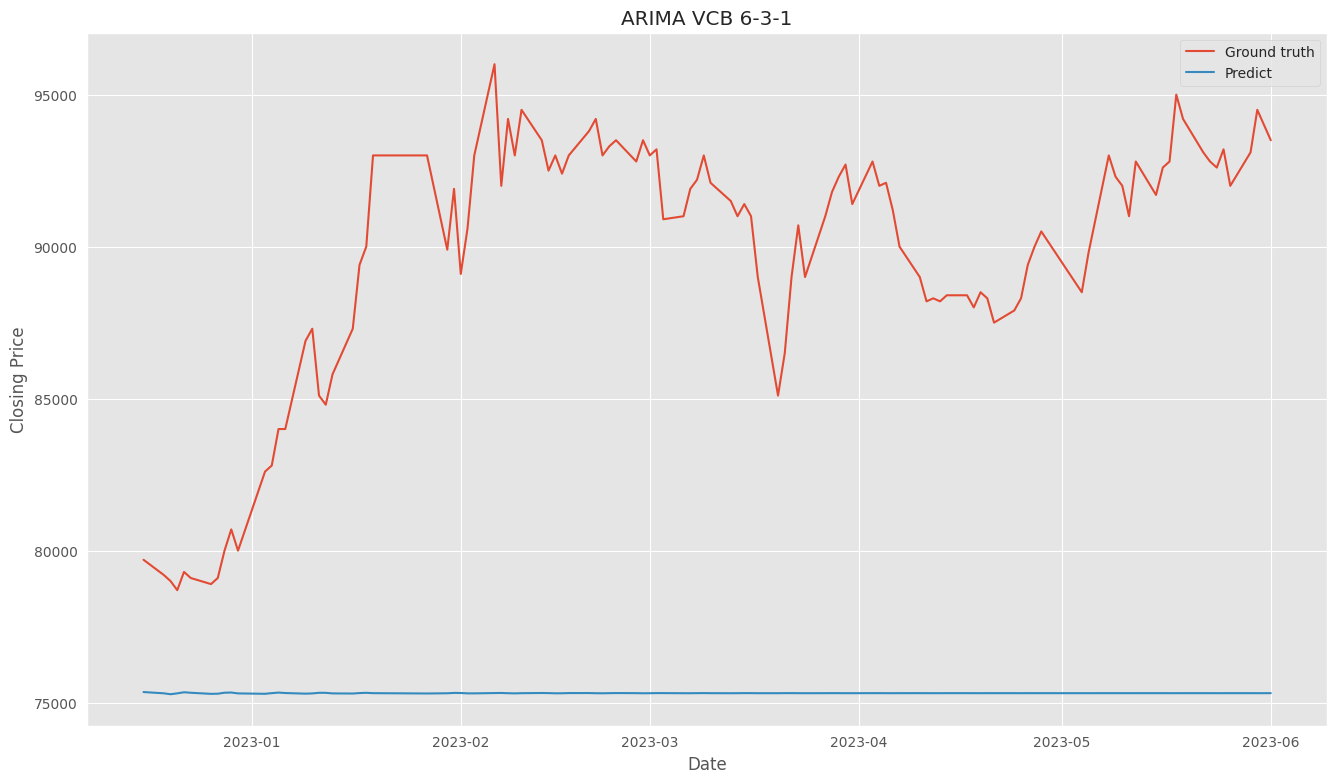

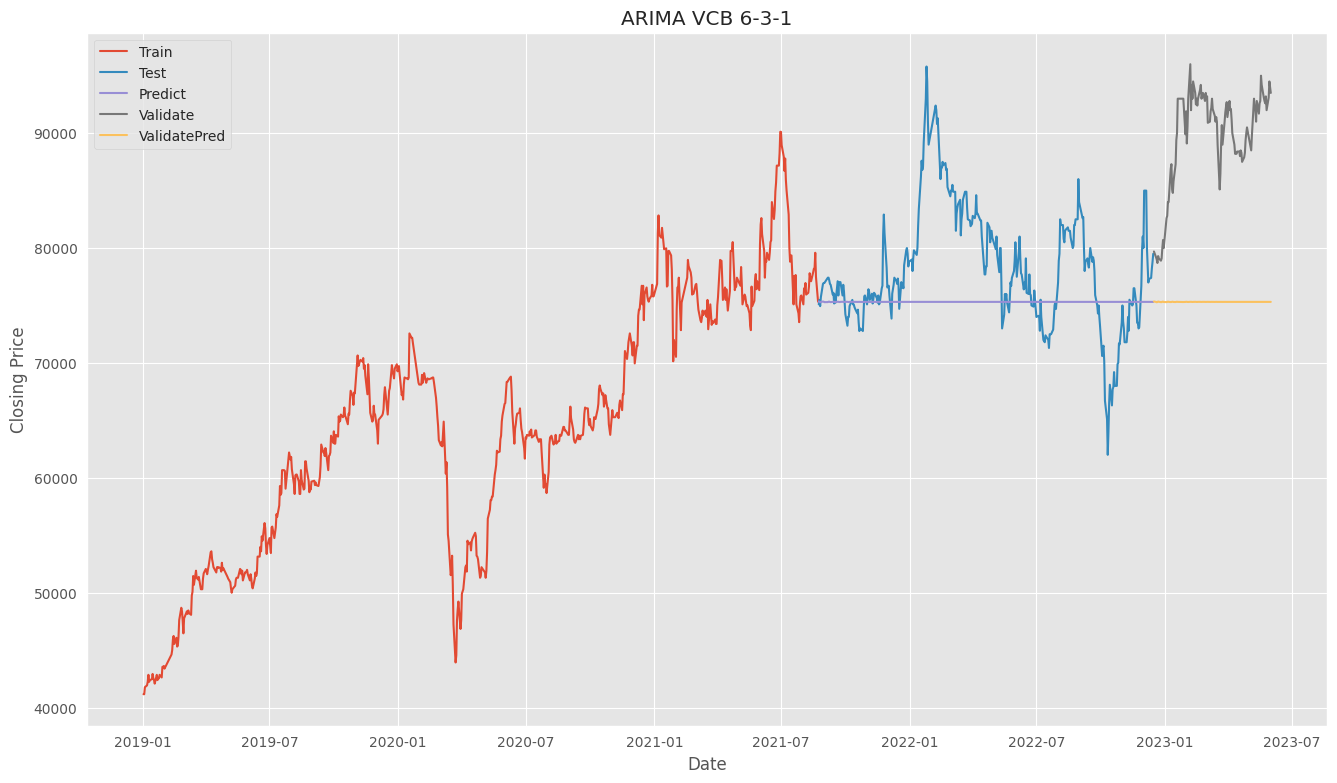

In [ ]:
data_preprocessing('/content/VCB Historical Data.csv', 0.6, 0.3, "ARIMA VCB 6-3-1")

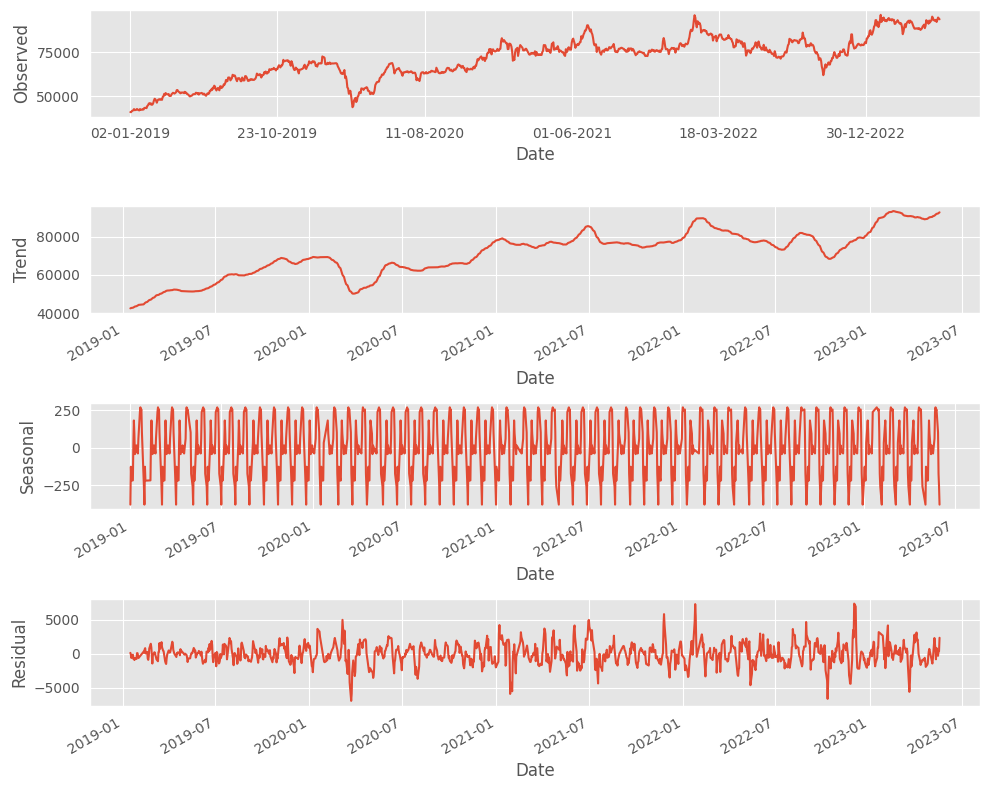

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13045.229, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13049.199, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13050.414, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13050.455, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13049.564, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13053.296, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13053.448, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13046.442, Time=1.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13046.400, Time=2.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13052.385, Time=0.78 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13051.401, Time=0.73 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13051.387, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=13048.161, Time=1.79 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=13044.966, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


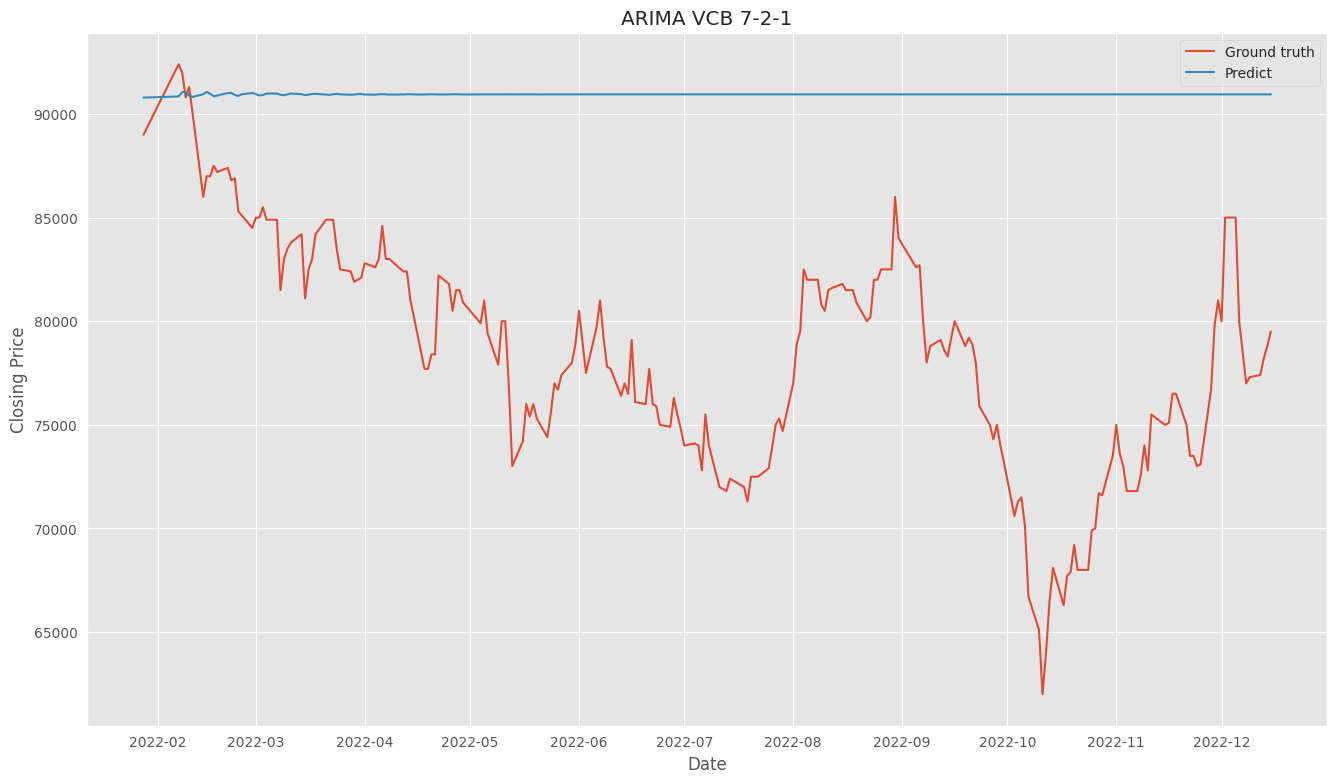

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 4515.62
MAPE: 3.73%
MAE: 3194.17


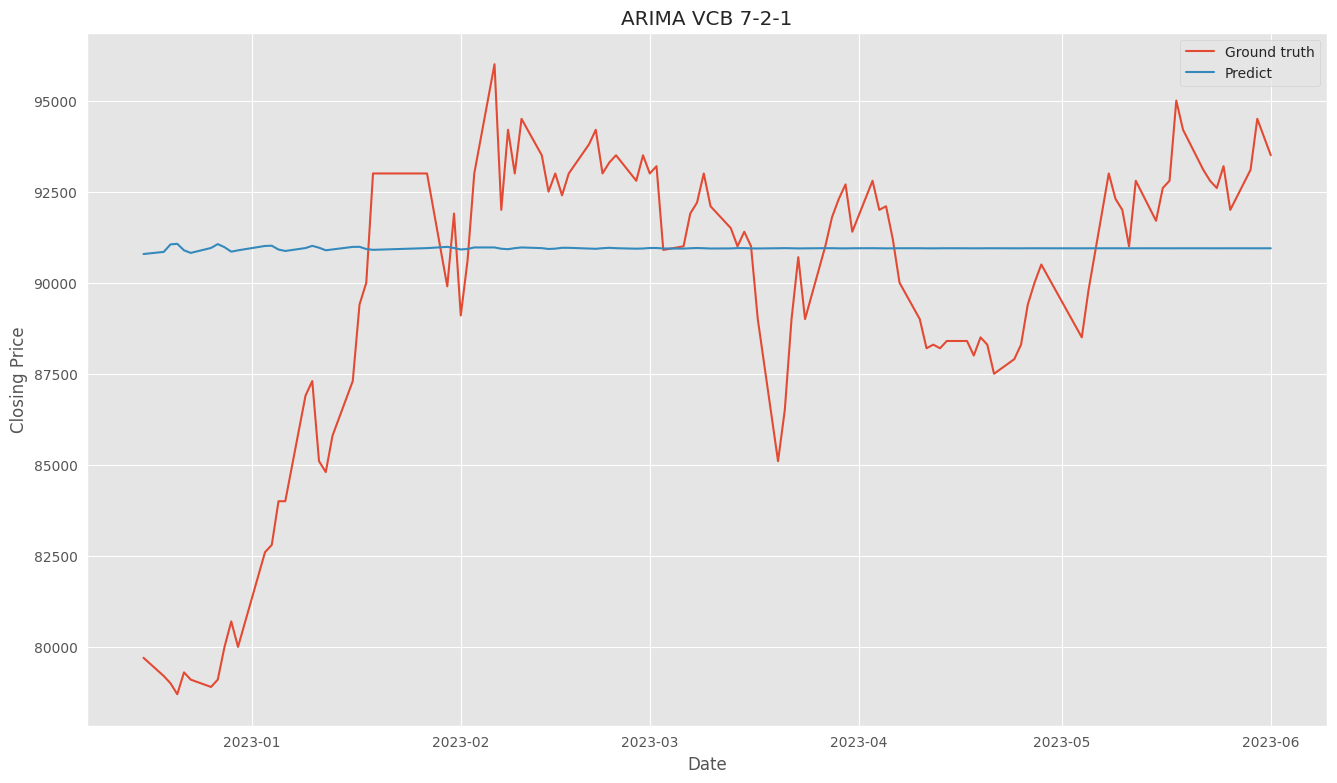

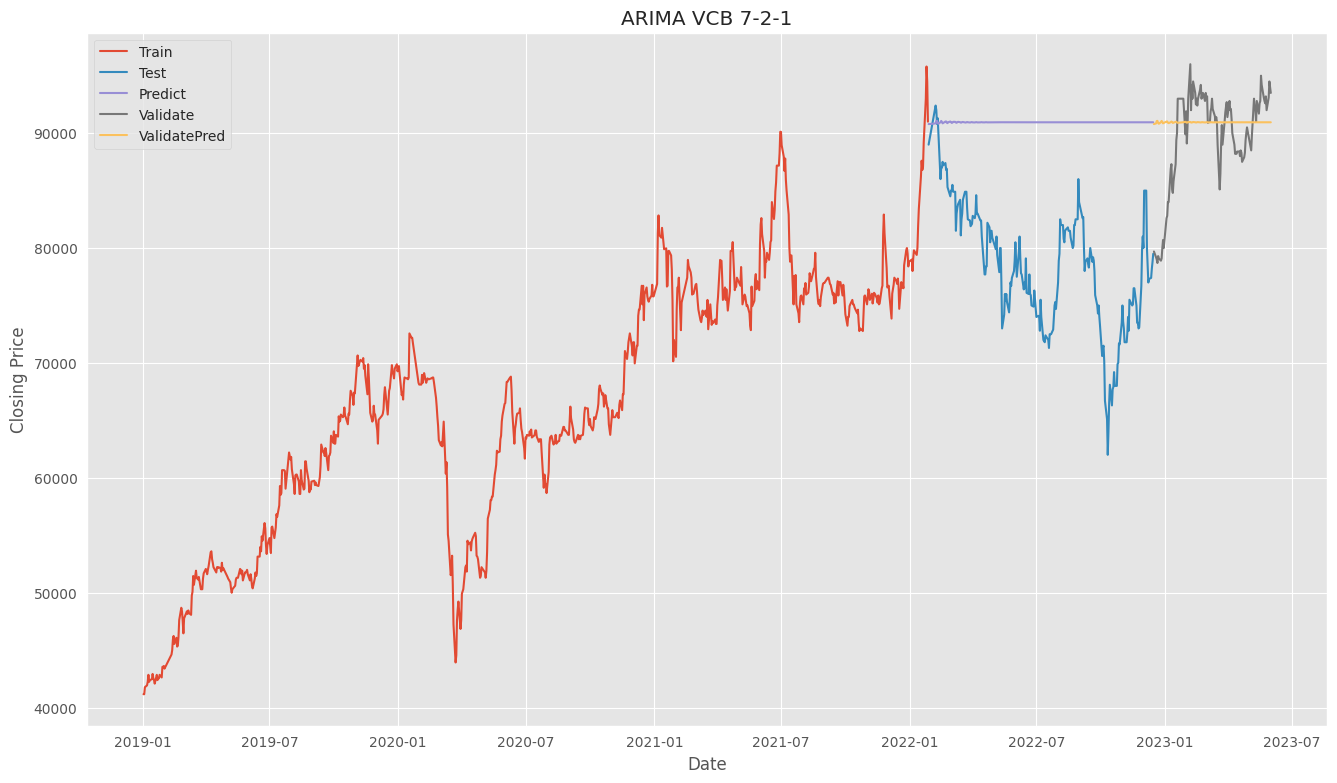

In [ ]:
data_preprocessing('/content/VCB Historical Data.csv', 0.7, 0.2, "ARIMA VCB 7-2-1")

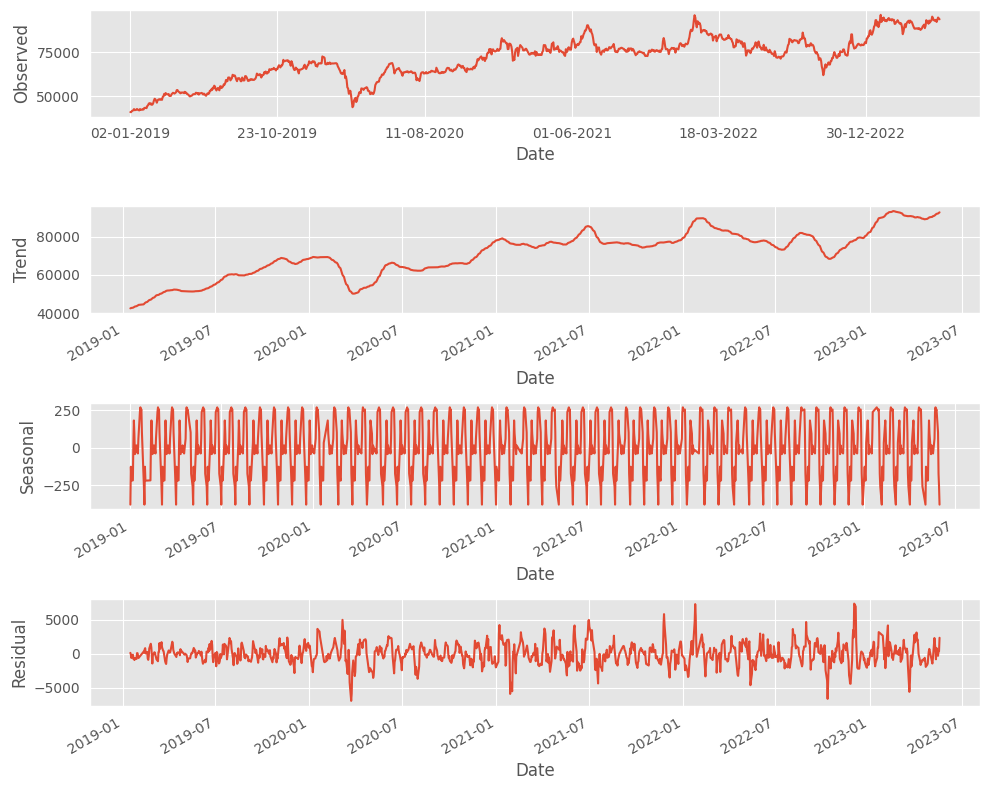

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14961.625, Time=2.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14963.530, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14965.272, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14965.276, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14962.276, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14968.793, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14968.715, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14963.228, Time=1.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14960.846, Time=3.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14968.226, Time=0.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14964.402, Time=4.88 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=14961.305, Time=2.00 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=14967.621, Time=0.89 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=14965.354, Time=2.87 sec
 ARIMA(2,1,3)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


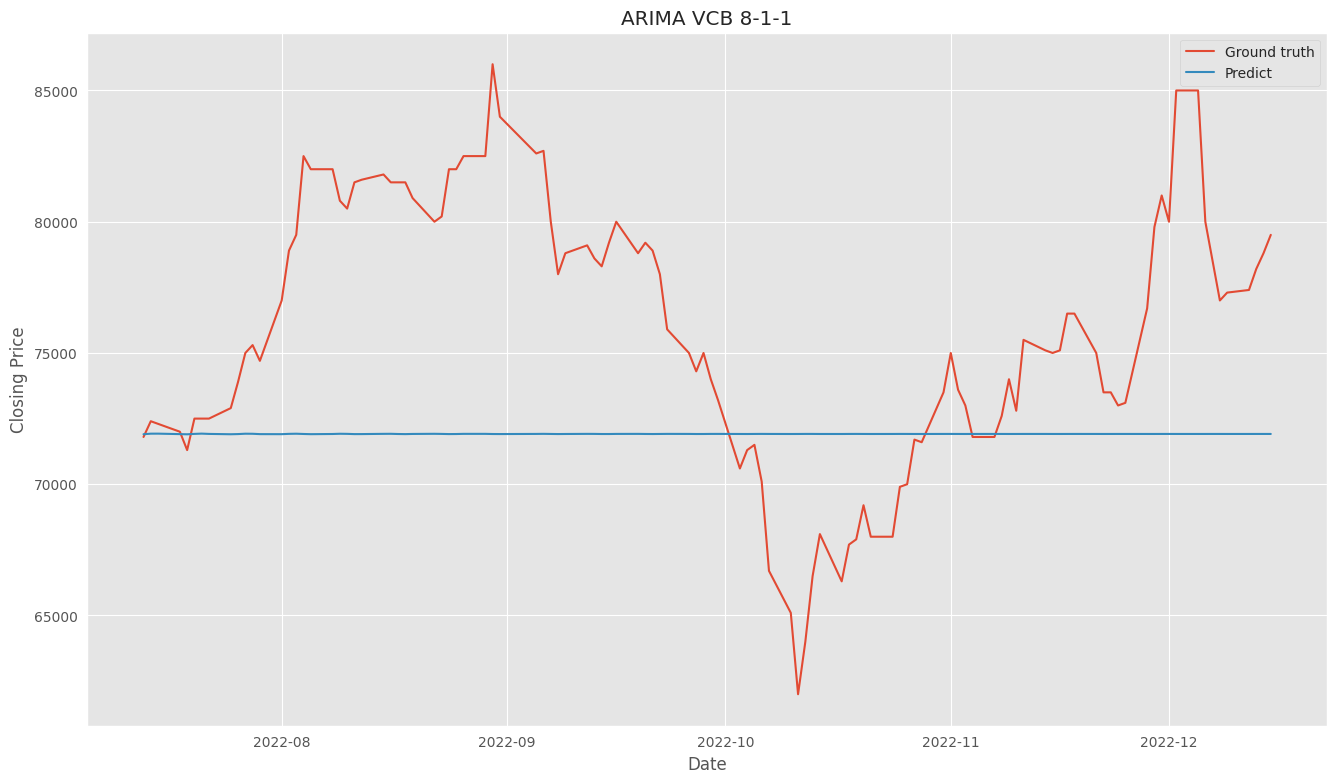

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 18288.14
MAPE: 19.61%
MAE: 17766.06


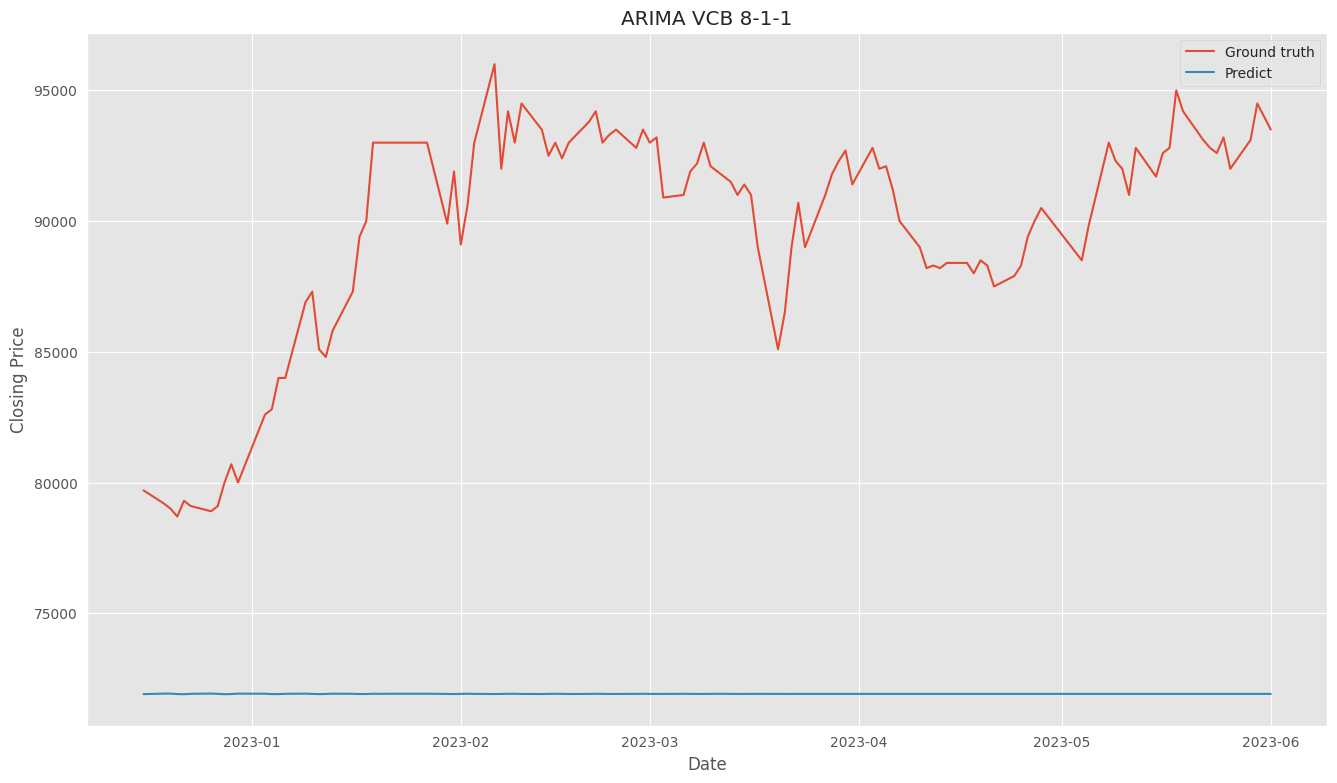

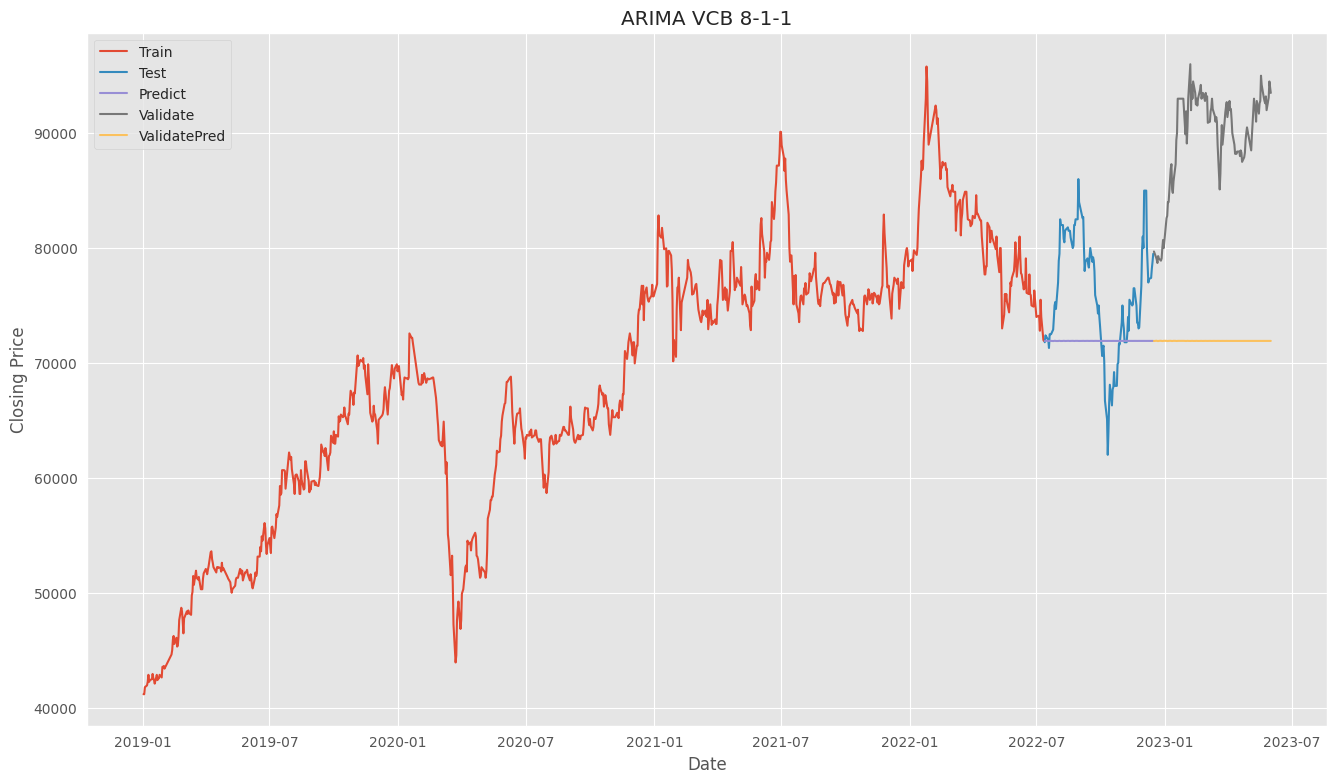

In [ ]:
data_preprocessing('/content/VCB Historical Data.csv', 0.8, 0.1, "ARIMA VCB 8-1-1")